In [1]:
import numpy as np
import numpy
import argparse
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.utils.data
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from PIL import Image
from engine import train_one_epoch, evaluate
import pandas as pd
from tqdm import tqdm

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

import utils
import transforms as T
import time

from scipy import ndimage
from skimage.feature import corner_harris, corner_peaks, corner_subpix
from skimage.feature import peak_local_max

In [2]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [3]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.backbone.body.conv1 = nn.Conv2d(36, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [4]:
class StarDataset(object):
    def __init__(self, path, transforms, window_size):
        self.root = path
        self.transforms = transforms
        pth = os.listdir(path)
        self.label_sequences = []

        self.dir_paths = []
        if os.path.isdir(path):
            self.dir_paths.append(path + '/')
            print(f"Loaded {path}")

        self.window_size = window_size
        self.seq_indexs = []
        self.seq_indexs.append((0, 0, len(pth)))

    def __len__(self):
        return self.seq_indexs[-1][-1]

    def __getitem__(self, idx):
        # load images and masks
        for i, start, end in self.seq_indexs:
            if idx >= start and idx < end:
                real_idx = idx - start

                if real_idx > 3:
                    entire_data1 = np.load(self.dir_paths[i] + '/' + str(int(real_idx) - 3) + ".npy", allow_pickle=True)
                    entire_data2 = np.load(self.dir_paths[i] + '/' + str(int(real_idx) - 2) + ".npy", allow_pickle=True)
                    entire_data3 = np.load(self.dir_paths[i] + '/' + str(int(real_idx) - 1) + ".npy", allow_pickle=True)
                    entire_data4 = np.load(self.dir_paths[i] + '/' + str(int(real_idx) + 0) + ".npy", allow_pickle=True)
                else:
                    entire_data1 = np.load(self.dir_paths[i] + '/' + str(int(real_idx)) + ".npy", allow_pickle=True)
                    entire_data2 = entire_data1
                    entire_data3 = entire_data1
                    entire_data4 = entire_data1

                data1 = entire_data1[0]
                data2 = entire_data2[0]
                data3 = entire_data3[0]
                data4 = entire_data4[0]
                
                masks = entire_data4[1]

                break

        input_data = self.preprocessing(data1, data2, data3, data4)
        return input_data, torch.as_tensor(np.array(masks), dtype=torch.uint8)

    def preprocessing(self, data1, data2, data3, data4):
        # 0 ground 1 air 2 building 3 spell 4 ground 5 air 6 building 7 spell 8 resource 9 vision 10 terrain
        temp = np.zeros([self.window_size, 9, data1.shape[1], data1.shape[2]])

        temp[0] = data1
        temp[1] = data2
        temp[2] = data3
        temp[3] = data4

        data = temp
        data = data.reshape(self.window_size * data.shape[1], data.shape[2], -1)
        # #data = data.reshape(self.window_size*data.shape[0],data.shape[1],-1)
        # label = np.array([label[0]/3456, label[1]/3720])
        return torch.FloatTensor(data)

In [5]:
testing_replay = ["212"]
datset_dir = "C:/Users/joo/PycharmProjects/starcraft_replay_reconstructor-devel/starcraft_replay_reconstructor-devel/result/"
model_dir = "C:/Users/joo/PycharmProjects/Automatic-Observer-for-StarCraft/save_models/jht/"

for i in testing_replay:    
    replay_dir = datset_dir + str(i)
    replay_name = int(replay_dir.split('/')[-1])
    print(replay_name)
    dataset = StarDataset(replay_dir, get_transform(train=False), window_size=4)
    
    dataset_len = len(dataset)    
    Start, End, Step = 0, len(dataset), 1
    test_img_array = []
    test_img_one_channel_array = []
    test_target_array = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = 2
    model = get_model_instance_segmentation(num_classes)
    model.load_state_dict(torch.load(model_dir+"model_28.pth"))
    model.to(device)
    model.eval()

    print("dataset_size:", End)
    for i in range(Start, End, Step):
        img_t = dataset[i][0]
        target_t = dataset[i][1]
        test_img_array.append(img_t)
        img_one_channel = img_t.sum(axis=0, keepdim=True)
        test_img_one_channel_array.append(img_one_channel)
        test_target_array.append(target_t)

    print("input load")
    vpx_array = []
    vpy_array = []
    predictions = []
    with torch.no_grad():
        for idx, i in tqdm(enumerate(test_img_array)):
            prediction = model(torch.unsqueeze(i, 0).to(device))
            if prediction[0]["boxes"].shape[0] == 0:
                prediction = model(torch.unsqueeze(i - 1, 0).to(device))
                vpx = int(prediction[0]["boxes"][0][0]) * 32
                vpy = int(prediction[0]["boxes"][0][1]) * 32
            else:
                vpx = int(prediction[0]["boxes"][0][0]) * 32
                vpy = int(prediction[0]["boxes"][0][1]) * 32
            predictions.append(prediction)
            if idx % 500 == 0:
                print("idx:  ", idx)
            vpx_array.append(vpx)
            vpy_array.append(vpy)
    
#     os.makedirs("./saved_xy/jht_20_gen/", exist_ok=True)
#     temp = np.zeros((dataset_len, 1))
#     for i in range(0, dataset_len):
#         temp[i] = int(i * 8)
#     temp2 = np.zeros((int(temp.max()), 1))
#     for i in range(0, int(temp.max())):
#         temp2[i] = i

#     dataset_temp = pd.DataFrame({"frame": temp[:, 0], "vpx": vpx_array[:], "vpy": vpy_array[:]})
#     dataset_temp2 = pd.DataFrame({"frame": temp2[:, 0]})
#     dataset = pd.merge(left=dataset_temp2, right=dataset_temp, how="left", on="frame")
#     dataset = dataset.fillna(method="ffill")
#     dataset.to_csv("./saved_xy/jht_20_gen/" + str(replay_name) + ".rep.vpd", header=True, index=False)
    

    print("saved")

212
Loaded C:/Users/joo/PycharmProjects/starcraft_replay_reconstructor-devel/starcraft_replay_reconstructor-devel/result/212


C:\Users\joo\.conda\envs\starcraft\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\joo\.conda\envs\starcraft\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dataset_size: 3531
input load


3it [00:06,  1.65s/it]

idx:   0


502it [00:50,  9.31it/s]

idx:   500


1002it [01:47,  8.75it/s]

idx:   1000


1502it [02:42, 10.74it/s]

idx:   1500


2002it [03:32, 10.16it/s]

idx:   2000


2502it [04:29,  7.92it/s]

idx:   2500


3002it [05:27,  8.28it/s]

idx:   3000


3502it [06:32,  7.26it/s]

idx:   3500


3531it [06:36,  8.91it/s]

saved


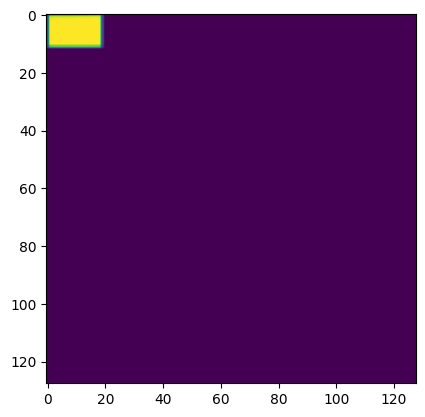

In [6]:
plt.imshow(predictions[300][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
plt.show()

### Total frame: 28239 (24 fps)
### Number of viewport:  28239/8: 3530 (3 fps)
### Game time: 19분 46초 (1,186): 1186 x 3  = 3558

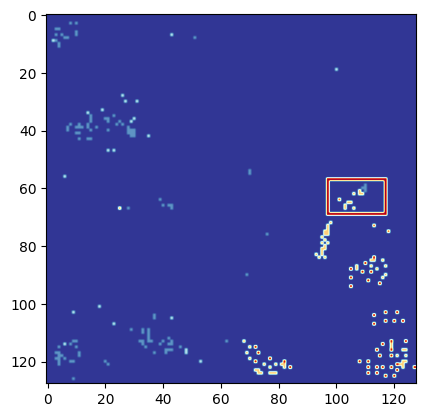

In [7]:
%matplotlib inline

fig, ax = plt.subplots(1,1)
acac1 = test_img_array[3000][:2].sum(axis=0).detach().numpy()    
acac1 = np.where(acac1 >= 1, 0.16, 0.0)
acac2 = test_img_array[3000][2:3].sum(axis=0).detach().numpy()    
acac2 = np.where(acac2 >= 1, 0.32, 0.0)
acac3 = test_img_array[3000][3:4].sum(axis=0).detach().numpy()    
acac3 = np.where(acac2 >= 1, 0.48, 0.0)

acac4 = test_img_array[3000][4:6].sum(axis=0).detach().numpy()    
acac4 = np.where(acac4 >= 1, 0.64, 0.0)
acac5 = test_img_array[3000][6:7].sum(axis=0).detach().numpy()    
acac5 = np.where(acac5 >= 1, 0.8, 0.0)
acac6 = test_img_array[3000][7:8].sum(axis=0).detach().numpy()    
acac6 = np.where(acac6 >= 1, 0.96, 0.0)

viewport_x = int(predictions[3000][0]['boxes'][0][0])
viewport_y = int(predictions[3000][0]['boxes'][0][1])

acac = acac1 + acac2 + acac3  + acac4  + acac5  + acac6
acac = np.where(acac >= 1, 0.96, acac)

acac[viewport_y:viewport_y+1, viewport_x:viewport_x+20]=1
acac[viewport_y+12:viewport_y+13, viewport_x:viewport_x+21]=1    
acac[viewport_y:viewport_y+12, viewport_x:viewport_x+1]=1
acac[viewport_y:viewport_y+12, viewport_x+20:viewport_x+21]=1
ax.imshow(acac, cmap="RdYlBu_r") # RdYlBu_r # gist_earth_r

plt.show() 

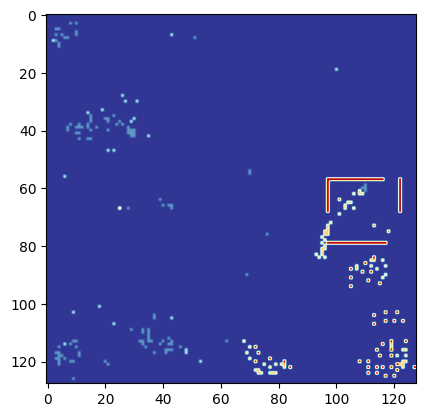

In [8]:
%matplotlib inline

fig, ax = plt.subplots(1,1)
acac1 = test_img_array[3000][:2].sum(axis=0).detach().numpy()    
acac1 = np.where(acac1 >= 1, 0.16, 0.0)
acac2 = test_img_array[3000][2:3].sum(axis=0).detach().numpy()    
acac2 = np.where(acac2 >= 1, 0.32, 0.0)
acac3 = test_img_array[3000][3:4].sum(axis=0).detach().numpy()    
acac3 = np.where(acac2 >= 1, 0.48, 0.0)

acac4 = test_img_array[3000][4:6].sum(axis=0).detach().numpy()    
acac4 = np.where(acac4 >= 1, 0.64, 0.0)
acac5 = test_img_array[3000][6:7].sum(axis=0).detach().numpy()    
acac5 = np.where(acac5 >= 1, 0.8, 0.0)
acac6 = test_img_array[3000][7:8].sum(axis=0).detach().numpy()    
acac6 = np.where(acac6 >= 1, 0.96, 0.0)

viewport_x = int(predictions[3000][0]['boxes'][0][0])
viewport_y = int(predictions[3000][0]['boxes'][0][1])

acac = acac1 + acac2 + acac3  + acac4  + acac5  + acac6
acac = np.where(acac >= 1, 0.96, acac)

acac[viewport_y:viewport_y+1, viewport_x:viewport_x+20]=1
acac[viewport_y+22:viewport_y+23, viewport_x:viewport_x+21]=1    
acac[viewport_y:viewport_y+12, viewport_x:viewport_x+1]=1
acac[viewport_y:viewport_y+12, viewport_x+25:viewport_x+26]=1
ax.imshow(acac, cmap="RdYlBu_r") # RdYlBu_r # gist_earth_r

plt.show() 

<IPython.core.display.Javascript object>


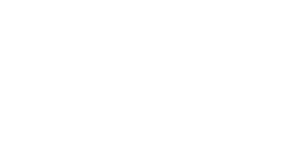

In [9]:
%matplotlib notebook
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import patches as patches

fig, ax = plt.subplots()
SCREEN_WIDTH, SCREEN_HEIGHT = 20, 12

ims = []

start, end = 1605, 1650
for i in range(start, end,1):
    acac1 = test_img_array[i][:1].sum(axis=0).detach().numpy()    
    acac1 = np.where(acac1 >= 0.1, 0.12, 0.0)
    acac2 = test_img_array[i][1:2].sum(axis=0).detach().numpy()    
    acac2 = np.where(acac2 >= 0.1, 0.24, 0.0)
    acac3 = test_img_array[i][2:3].sum(axis=0).detach().numpy()    
    acac3 = np.where(acac3 >= 0.1, 0.36, 0.0)
    acac4 = test_img_array[i][3:4].sum(axis=0).detach().numpy()    
    acac4 = np.where(acac4 >= 0.1, 0.48, 0.0)

    acac5 = test_img_array[i][4:5].sum(axis=0).detach().numpy()    
    acac5 = np.where(acac5 >= 0.1, 0.6, 0.0)
    acac6 = test_img_array[i][5:6].sum(axis=0).detach().numpy()    
    acac6 = np.where(acac6 >= 0.1, 0.72, 0.0)
    acac7 = test_img_array[i][6:7].sum(axis=0).detach().numpy()    
    acac7 = np.where(acac7 >= 0.1, 0.84, 0.0)
    acac8 = test_img_array[i][7:8].sum(axis=0).detach().numpy()    
    acac8 = np.where(acac8 >= 0.1, 0.96, 0.0)

    acac = acac1 + acac2 + acac3  + acac4  + acac5  + acac6
    acac = np.where(acac >= 1, 0.96, acac)
    
    viewport_x = int(predictions[i][0]['boxes'][0][0])
    viewport_y = int(predictions[i][0]['boxes'][0][1])
    
    acac[viewport_y:viewport_y+1, viewport_x:viewport_x+20]=1
    acac[viewport_y+12:viewport_y+13, viewport_x:viewport_x+21]=1    
    acac[viewport_y:viewport_y+12, viewport_x:viewport_x+1]=1
    acac[viewport_y:viewport_y+12, viewport_x+20:viewport_x+21]=1        
        
    im = ax.imshow(acac, cmap="RdYlBu_r")
    ttl = plt.text(0.5, 1.01, i, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    txt = plt.text(i,i,i)
    ims.append([im, ttl, txt])

ani = animation.ArtistAnimation(fig, ims, interval=100)
# ani.save('Oserver_'+str(start)+'_'+str(end)+'_.gif', writer='imagemagick', fps=8)

# Replay Buffer (s, a, r, s')

In [10]:
def get_state(fr):
    acac1 = test_img_array[fr][:2].sum(axis=0).detach().numpy()    
    acac1 = np.where(acac1 >= 1, 0.16, 0.0)
    acac2 = test_img_array[fr][2:3].sum(axis=0).detach().numpy()    
    acac2 = np.where(acac2 >= 1, 0.32, 0.0)
    acac3 = test_img_array[fr][3:4].sum(axis=0).detach().numpy()    
    acac3 = np.where(acac2 >= 1, 0.48, 0.0)

    acac4 = test_img_array[fr][4:6].sum(axis=0).detach().numpy()    
    acac4 = np.where(acac4 >= 1, 0.64, 0.0)
    acac5 = test_img_array[fr][6:7].sum(axis=0).detach().numpy()    
    acac5 = np.where(acac5 >= 1, 0.8, 0.0)
    acac6 = test_img_array[fr][7:8].sum(axis=0).detach().numpy()    
    acac6 = np.where(acac6 >= 1, 0.96, 0.0)

    viewport_x = int(predictions[fr][0]['boxes'][0][0])
    viewport_y = int(predictions[fr][0]['boxes'][0][1])

    acac = acac1 + acac2 + acac3  + acac4  + acac5  + acac6
    acac = np.where(acac >= 1, 0.96, acac)
    
    partial_state = acac.copy()[viewport_y:viewport_y+12, viewport_x:viewport_x+20]
    
    acac[viewport_y:viewport_y+1, viewport_x:viewport_x+20]=1
    acac[viewport_y+12:viewport_y+13, viewport_x:viewport_x+21]=1    
    acac[viewport_y:viewport_y+12, viewport_x:viewport_x+1]=1
    acac[viewport_y:viewport_y+12, viewport_x+20:viewport_x+21]=1
    
    return acac, (viewport_x, viewport_y), partial_state

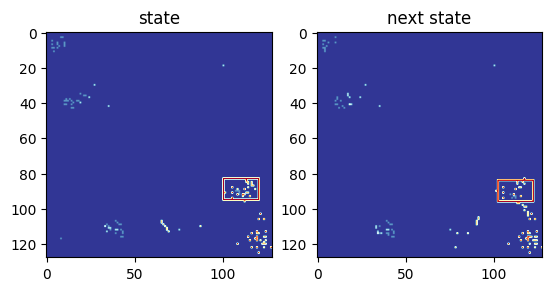

In [11]:
%matplotlib inline

fr = 1500
fig, ax1 = plt.subplots(1,2)
acac, (viewport_x, viewport_y), _ = get_state(fr)

ax1[0].imshow(acac, cmap="RdYlBu_r")
ax1[0].set_title("state")

acac, (viewport_x, viewport_y), _ = get_state(fr+25)

ax1[1].imshow(acac, cmap="RdYlBu_r")
ax1[1].set_title("next state")

plt.show()

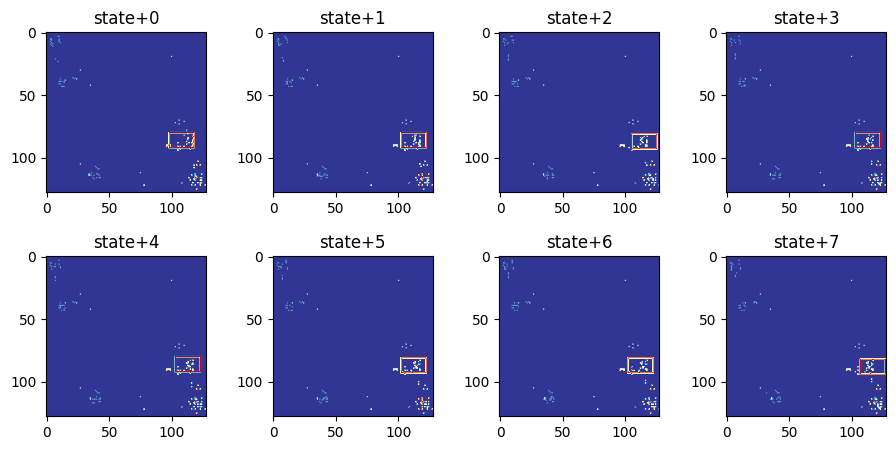

In [12]:
%matplotlib inline

x_axis, y_axis = 2, 4
fr_interval = 1
fr = 1615
fig, ax1 = plt.subplots(x_axis, y_axis)

for i in range(x_axis):
    for j in range(y_axis):
        frame_number = i*fr_interval*y_axis + j*fr_interval
        acac, (viewport_x, viewport_y), _ = get_state(fr+frame_number)
        ax1[i,j].imshow(acac, cmap="RdYlBu_r")
        ax1[i,j].set_title("state+" + str(frame_number))

fig.tight_layout(pad=1.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.5,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.4)

plt.show()

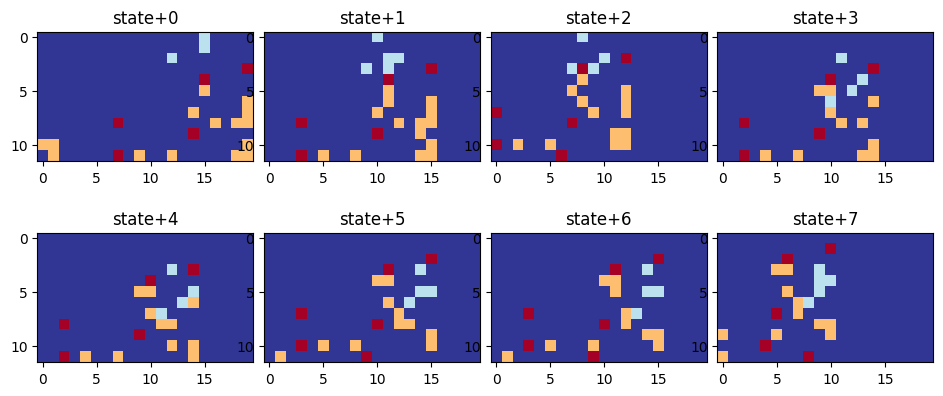

In [13]:
%matplotlib inline

x_axis, y_axis = 2, 4
fr_interval = 1
fr = 1615
fig, ax1 = plt.subplots(x_axis, y_axis)

for i in range(x_axis):
    for j in range(y_axis):
        frame_number = i*fr_interval*y_axis + j*fr_interval
        _, _, acac = get_state(fr+frame_number)
        ax1[i,j].imshow(acac, cmap="RdYlBu_r")
        ax1[i,j].set_title("state+" + str(frame_number))


#fig.tight_layout(pad=1.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.5,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.1)

plt.show()

## Changed state by action

In [14]:
def changed_state_by_action(fr):
    acac1 = test_img_array[fr][:2].sum(axis=0).detach().numpy()    
    acac1 = np.where(acac1 >= 1, 0.16, 0.0)
    acac2 = test_img_array[fr][2:3].sum(axis=0).detach().numpy()    
    acac2 = np.where(acac2 >= 1, 0.32, 0.0)
    acac3 = test_img_array[fr][3:4].sum(axis=0).detach().numpy()    
    acac3 = np.where(acac2 >= 1, 0.48, 0.0)

    acac4 = test_img_array[fr][4:6].sum(axis=0).detach().numpy()    
    acac4 = np.where(acac4 >= 1, 0.64, 0.0)
    acac5 = test_img_array[fr][6:7].sum(axis=0).detach().numpy()    
    acac5 = np.where(acac5 >= 1, 0.8, 0.0)
    acac6 = test_img_array[fr][7:8].sum(axis=0).detach().numpy()    
    acac6 = np.where(acac6 >= 1, 0.96, 0.0)

    viewport_x = int(predictions[fr][0]['boxes'][0][0])
    viewport_y = int(predictions[fr][0]['boxes'][0][1])

    acac = acac1 + acac2 + acac3  + acac4  + acac5  + acac6
    acac = np.where(acac >= 1, 0.96, acac)
    
    action_state = []     
    # 0: up      # 1: up + right     # 2: right     # 3: right + down
    # 4: down    # 5: down + left    # 6: left     # 7: left + up     # 8: stop    
    
    value = 1
    
    action_state.append(acac.copy()[viewport_y-value:viewport_y+12-value, viewport_x-value:viewport_x+20-value]) # 0 left + up
    
    action_state.append(acac.copy()[viewport_y-value:viewport_y+12-value, viewport_x:viewport_x+20]) # 1 up
    
    action_state.append(acac.copy()[viewport_y-value:viewport_y+12-value, viewport_x+value:viewport_x+20+value]) # 2 up + right    
    
    action_state.append(acac.copy()[viewport_y:viewport_y+12, viewport_x-value:viewport_x+20-value]) # 3 left
    
    action_state.append(acac.copy()[viewport_y:viewport_y+12, viewport_x:viewport_x+20]) # 4 stop
    
    action_state.append(acac.copy()[viewport_y:viewport_y+12, viewport_x+value:viewport_x+20+value]) # 5 right    
    action_state.append(acac.copy()[viewport_y+value:viewport_y+12+value, viewport_x-value:viewport_x+20-value]) # 6 down + left
      
    action_state.append(acac.copy()[viewport_y+value:viewport_y+12+value, viewport_x:viewport_x+20]) # 7 down
    action_state.append(acac.copy()[viewport_y+value:viewport_y+12+value, viewport_x+value:viewport_x+20+value]) # 8 right + down  
        
    return action_state

In [15]:
def changed_state_by_action1(fr, action):    

    viewport_x = int(predictions[fr][0]['boxes'][0][0])
    viewport_y = int(predictions[fr][0]['boxes'][0][1])

    acac = test_img_array[fr][0:8]    
    
    action_state = []     
    # 0: left+up   # 1: up         # 2: up+right   #3: left              #4: stop
    # 5: right    # 6: down+left   # 7: down       # 8: right + down    
    
    value = 1
    
    current_state_viewport = acac.clone()[:,viewport_y:viewport_y+12, viewport_x:viewport_x+20]
    next_state_viewport = test_img_array[fr+1][0:8][:,viewport_y:viewport_y+12, viewport_x:viewport_x+20]
    
    a = {0: ['-','-'], 1: ['-','0'],2: ['-','+'],3: ['0','-'],4: ['0', '0'],
        5: ['0','+'],6: ['+','-'],7: ['+','0'],8: ['+','+']}
    
    action_list = []
    
    if a[action][0] == "-":
        action_list.append(viewport_y-value)
        action_list.append(viewport_y+12-value)
    elif a[action][0] == "0":
        action_list.append(viewport_y)
        action_list.append(viewport_y+12)
    elif a[action][0] == "+":
        action_list.append(viewport_y+value)
        action_list.append(viewport_y+12+value)
        
    if a[action][1] == "-":
        action_list.append(viewport_x-value)
        action_list.append(viewport_x+20-value)
    elif a[action][1] == "0":
        action_list.append(viewport_x)
        action_list.append(viewport_x+20)
    elif a[action][1] == "+":
        action_list.append(viewport_x+value)
        action_list.append(viewport_x+20+value)    
    
    next_state_viewport_by_action = test_img_array[fr+1][0:8][:,action_list[0]:action_list[1], action_list[2]:action_list[3]]
    next_next_state_viewport_by_action = test_img_array[fr+1][0:8][:,action_list[0]:action_list[1], action_list[2]:action_list[3]]
    
    current_state = torch.cat([current_state_viewport, next_state_viewport])
    next_state = torch.cat([next_state_viewport_by_action, next_next_state_viewport_by_action])
        
    return current_state, next_state

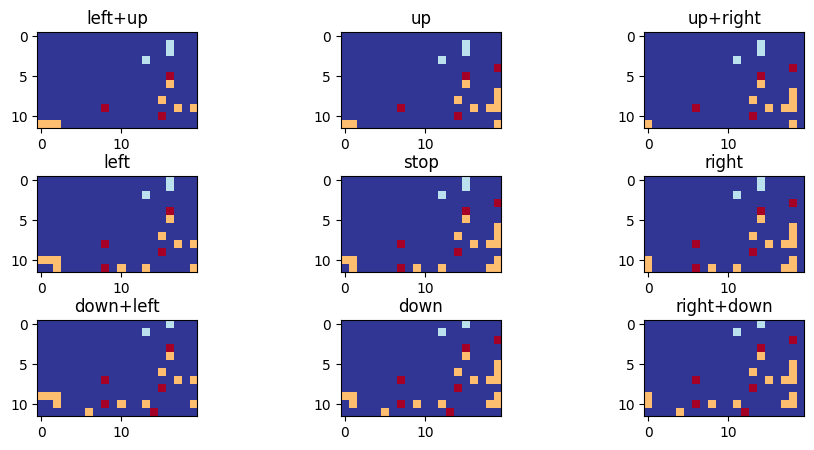

In [84]:
%matplotlib inline

x_axis, y_axis = 3, 3
fr_interval = 3
fr = 1615
frame_number = 0
fig, ax1 = plt.subplots(x_axis, y_axis)
acac  = changed_state_by_action(fr+frame_number)

action_ = ["left+up", "up", "up+right", "left", "stop", "right", "down+left", "down", "right+down"]    

for i in range(x_axis):
    for j in range(y_axis):         
        ax1[i,j].imshow(acac[i*x_axis+j], cmap="RdYlBu_r")
        ax1[i,j].set_title(action_[i*x_axis+j])

fig.tight_layout(pad=1.0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.5,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.5)


plt.show()

In [159]:
from skimage.metrics import mean_squared_error
y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])
print(mean_squared_error(y_true, y_pred))

print((0.5**2*2 +1)/4)

#print((y_true-y_pred)**2).sum())

0.375
0.375


In [167]:
for i in range(8):
    print(i)
    print(test_img_array[1100][i].min())
    print(test_img_array[1100][i].max())
    print("########")

0
tensor(0.)
tensor(3.)
########
1
tensor(0.)
tensor(2.)
########
2
tensor(0.)
tensor(1.)
########
3
tensor(0.)
tensor(1.)
########
4
tensor(0.)
tensor(2.)
########
5
tensor(0.)
tensor(1.)
########
6
tensor(0.)
tensor(1.)
########
7
tensor(0.)
tensor(1.)
########


In [170]:
test_img_array[1100][2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor(3.)

2642
0:  0.008
1:  0.008
2:  0.0
3:  0.008
4:  0.008
5:  0.008
6:  0.008
7:  0.008
8:  0.008


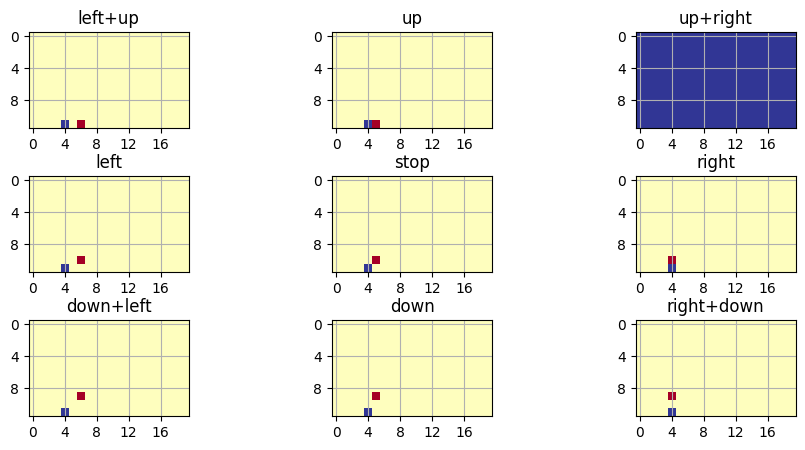

In [144]:
import random
%matplotlib inline

x_axis, y_axis = 3, 3
fr_interval = 3
#fr = 1625
fr = random.randint(1,3500)
print(fr)
fig, ax1 = plt.subplots(x_axis, y_axis)

action_ = ["left+up", "up", "up+right", "left", "stop", "right", "down+left", "down", "right+down"]    

for i in range(9):
    state, next_state  = changed_state_by_action1(fr,i)
    #print(int(i/3),int(i%3))
    #ax1[int(i/3),int(i%3)].imshow(next_state.sum(axis=0).detach().numpy()    , cmap="RdYlBu_r")
    ax1[int(i/3),int(i%3)].imshow(next_state[:8].sum(axis=0).detach().numpy()-state[:8].sum(axis=0).detach().numpy(), cmap="RdYlBu_r")
    ax1[int(i/3),int(i%3)].set_title(action_[i])
    ax1[int(i/3),int(i%3)].set_xticks(range(0,20,4))
    ax1[int(i/3),int(i%3)].set_yticks(range(0,12,4))
    ax1[int(i/3),int(i%3)].grid() 
    
    #reward1 = mean_squared_error(state[:8].sum(axis=0).detach().numpy(),next_state[:8].sum(axis=0).detach().numpy())
    reward1 = mean_squared_error(state[:8].sum(axis=0).detach().numpy(),next_state[:8].sum(axis=0).detach().numpy())
    print(str(i) + ": ",np.round(reward1,3))

    #ax1[i,j].set_title(action_[i*x_axis+j])


# for i,j in ax1:
#     i.set_xticks(range(0,20,4))
#     i.set_yticks(range(0,12,4))
#     i.grid() 
    
fig.tight_layout(pad=1.0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.5,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.5)

plt.show()


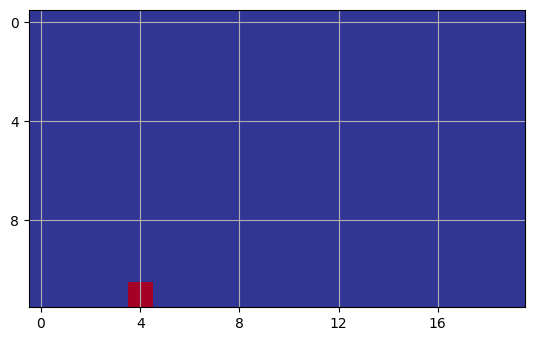

In [145]:
fr = 2642
#plt.imshow(predictions[1615][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())

plt.xticks(range(0,20,4))
plt.yticks(range(0,12,4))
plt.grid() 
    
plt.imshow(state[:8].sum(axis=0).detach().numpy(), cmap="RdYlBu_r")



In [18]:
frame_number

7

In [19]:
def render(fr): # fr = frame nubmer
    state1 = test_img_array[fr][:2].sum(axis=0).detach().numpy()    
    state1 = np.where(state1 >= 1, 0.16, 0.0)
    state2 = test_img_array[fr][2:3].sum(axis=0).detach().numpy()    
    state2 = np.where(state2 >= 1, 0.32, 0.0)
    state3 = test_img_array[fr][3:4].sum(axis=0).detach().numpy()    
    state3 = np.where(state2 >= 1, 0.48, 0.0)

    state4 = test_img_array[fr][4:6].sum(axis=0).detach().numpy()    
    state4 = np.where(state4 >= 1, 0.64, 0.0)
    state5 = test_img_array[fr][6:7].sum(axis=0).detach().numpy()    
    state5 = np.where(state5 >= 1, 0.8, 0.0)
    state6 = test_img_array[fr][7:8].sum(axis=0).detach().numpy()    
    state6 = np.where(state6 >= 1, 0.96, 0.0)

    viewport_x = int(predictions[fr][0]['boxes'][0][0])
    viewport_y = int(predictions[fr][0]['boxes'][0][1])

    state = state1 + state2 + state3  + state4  + state5  + state6
    state = np.where(state >= 1, 0.96, state)
    
    action_state = []    
    current_state = current_state_pos + next_state_current_pos
    # (2, 20, 12)    
    next_state = 0
    
    return current_state, next_state
    

## Collecting Replay Buffer

In [20]:
def changed_state_by_action1(fr, action):    

    viewport_x = int(predictions[fr][0]['boxes'][0][0])
    viewport_y = int(predictions[fr][0]['boxes'][0][1])

    acac = test_img_array[fr][0:8]    
    
    action_state = []     
    # 0: left+up   # 1: up         # 2: up+right   #3: left              #4: stop
    # 5: right    # 6: down+left   # 7: down       # 8: right + down    
    
    value = 1
    
    current_state_viewport = acac.clone()[:,viewport_y:viewport_y+12, viewport_x:viewport_x+20]
    next_state_viewport = test_img_array[fr+1][0:8][:,viewport_y:viewport_y+12, viewport_x:viewport_x+20]
    
    a = {0: ['-','-'], 1: ['-','0'],2: ['-','+'],3: ['0','-'],4: ['0', '0'],
        5: ['0','+'],6: ['+','-'],7: ['+','0'],8: ['+','+']}
    
    action_list = []
    
    if a[action][0] == "-":
        action_list.append(viewport_y-value)
        action_list.append(viewport_y+12-value)
    elif a[action][0] == "0":
        action_list.append(viewport_y)
        action_list.append(viewport_y+12)
    elif a[action][0] == "+":
        action_list.append(viewport_y+value)
        action_list.append(viewport_y+12+value)
        
    if a[action][1] == "-":
        action_list.append(viewport_x-value)
        action_list.append(viewport_x+20-value)
    elif a[action][1] == "0":
        action_list.append(viewport_x)
        action_list.append(viewport_x+20)
    elif a[action][1] == "+":
        action_list.append(viewport_x+value)
        action_list.append(viewport_x+20+value)    
    
    next_state_viewport_by_action = test_img_array[fr+1][0:8][:,action_list[0]:action_list[1], action_list[2]:action_list[3]]
    next_next_state_viewport_by_action = test_img_array[fr+1][0:8][:,action_list[0]:action_list[1], action_list[2]:action_list[3]]
    
    current_state = torch.cat([current_state_viewport, next_state_viewport])
    next_state = torch.cat([next_state_viewport_by_action, next_next_state_viewport_by_action])
        
    return current_state, next_state

In [273]:
aab={0:50-20}
print(aab)

x = torch.Tensor(  [[ 0.6000, 0.0000, 0.0000, 0.0000],
                    [ 0.0000, 0.4000, 0.0000, 0.0000],
                    [ 0.0000, 0.0000, 1.2000, 0.0000],
                    [ 0.0000, 0.0000, 4.0000, 0.0000]])
print(torch.nonzero(x))

{0: 30}
tensor([[0, 0],
        [1, 1],
        [2, 2],
        [3, 2]])


In [355]:
import math
import random
import gym
from gym import spaces
import pandas as pd
import numpy as np
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

class StarObserverEnv(gym.Env):
    def __init__(self, render_mode=None):
        super(StarObserverEnv, self).__init__()        
        
        #self.reward_range = (0, MAX_ACCOUNT_BALANCE)
        N_DISCRETE_ACTIONS = 9
        N_CHANNELS, HEIGHT, WIDTH = 16, 12, 20
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.current_step = 0
        self.current_episode_step = 0
        self.current_action = 0
        # self.previous_state = torch.zeros(16, 20, 12)
        self.render_mode = render_mode
        
        self.observation_space = spaces.Box(low=0, high=1, shape=
                    (N_CHANNELS, HEIGHT, WIDTH), dtype=np.float16)
        self.total_angle = []
        self.action_ = ["left,up", "up", "up,right", "left", "stop", "right", "down,left", "down", "right,down"]   
        self.action_dic = {0: ['-','-'], 1: ['-','0'],2: ['-','+'],3: ['0','-'],4: ['0', '0'],
            5: ['0','+'],6: ['+','-'],7: ['+','0'],8: ['+','+']}
        self.pre_frame_center_coor = 0,0
        self.curr_frame_center_coor = 0,0
        
    def _next_observation(self):

        viewport_x = int(predictions[self.current_step][0]['boxes'][0][0])
        viewport_y = int(predictions[self.current_step][0]['boxes'][0][1])        
        
        if viewport_x == 0 or viewport_y == 0 or viewport_x == (128-20) or viewport_y == (128-12) :
            #print(viewport_x, viewport_y)
            done = 1
            return 0,0, done

        current_state_channel = test_img_array[self.current_step][0:8]    

        current_state_viewport = current_state_channel.clone()[:,viewport_y:viewport_y+12, viewport_x:viewport_x+20]
        next_state_viewport = test_img_array[self.current_step+1][0:8][:,viewport_y:viewport_y+12, viewport_x:viewport_x+20]
        current_state = torch.cat([current_state_viewport, next_state_viewport])
        
        ##########################################################################        
        

        # 0: left+up   # 1: up         # 2: up+right   #3: left              #4: stop
        # 5: right    # 6: down+left   # 7: down       # 8: right + down    

        action_list = []
        pixel_speed = 1

        if self.action_dic[action][0] == "-":            
            action_list.append(viewport_y-pixel_speed)
            action_list.append(viewport_y+12-pixel_speed)
        elif self.action_dic[action][0] == "0":
            action_list.append(viewport_y)
            action_list.append(viewport_y+12)
        elif self.action_dic[action][0] == "+":
            action_list.append(viewport_y+pixel_speed)
            action_list.append(viewport_y+12+pixel_speed)

        if self.action_dic[action][1] == "-":
            action_list.append(viewport_x-pixel_speed)
            action_list.append(viewport_x+20-pixel_speed)
        elif self.action_dic[action][1] == "0":
            action_list.append(viewport_x)
            action_list.append(viewport_x+20)
        elif self.action_dic[action][1] == "+":
            action_list.append(viewport_x+pixel_speed)
            action_list.append(viewport_x+20+pixel_speed)

        next_state_viewport_by_action = test_img_array[self.current_step+1][0:8][:,action_list[0]:action_list[1], action_list[2]:action_list[3]]
        next_next_state_viewport_by_action = test_img_array[self.current_step+1][0:8][:,action_list[0]:action_list[1], action_list[2]:action_list[3]]
        next_state = torch.cat([next_state_viewport_by_action, next_next_state_viewport_by_action])

        return current_state, next_state, 0

    def get_angle(self, center_coordinate1, center_coordinate2):
        y1, x1 = center_coordinate1
        y2, x2 = center_coordinate2
#         x1, y1 = center_coordinate1
#         x2, y2 = center_coordinate2
        #print("direction vector",(y2-y1, x2-x1))
        #degrees = math.degrees(math.atan2(y2-y1, x2-x1))
        degrees = math.degrees(math.atan2(y1-y2, x1-x2))
            
        if degrees < 0: # 0~ 180 ~ 0 ~ -180 -> 0 ~ 360
            degrees = 360-abs(degrees)
            
        return (720- degrees) % 360
        
    def find_center_coordinate(self, frame):
        frame = torch.sum(frame,0)
        center_cordinate =  torch.nonzero(frame).sum(0).numpy() / len(torch.nonzero(frame)) # (y,x로 찍혀나옴)
        return center_cordinate        
        
    def step(self, action):
        
        #obs = self._next_observation()
        
        done = 0
        reward = 0
        angle_reward = 0
        distance_reward = 0
        
        action_idx = action
        
        self.current_action = action        
        self.current_step += 1         
        self.current_episode_step += 1
        
        state, next_state, done = self._next_observation()
        
        if self.current_episode_step == 20:
            self.current_episode_step = 0
            done = 1
            
        self.action_dic2 = {0:0, 1:45, 2:90, 3: 315, 4:0,
            5:135 , 6:270, 7:225, 8:180}
        
#         self.action_to_angle = {0:225, 1:170, 2:315, 3: 180, 4:0,
#             5:0 , 6:135, 7:90, 8:45}
        self.action_to_angle = {0:135, 1:90, 2:45, 3: 180, 4:0,
            5:0 , 6:225, 7:270, 8:315}
            
        #print("Frame: ", self.current_step)
        
        ######################################################################################
        ####################################### Reward #######################################
        ######################################################################################        
        
        #print(state[8:].sum(axis=0).detach().numpy(), next_state[:8].sum(axis=0).detach().numpy())
        
        if done == 0:
            
#             reward1 = mean_squared_error(state[:8].sum(axis=0).detach().numpy(),next_state[:8].sum(axis=0).detach().numpy())
            
            #pre_frame_center_coor = self.find_center_coordinate(state[:8].sum(axis=0))
            #curr_frame_center_coor = self.find_center_coordinate(next_state[:8].sum(axis=0))
            
            self.pre_frame_center_coor = self.find_center_coordinate(state[:8])        
            self.curr_frame_center_coor = self.find_center_coordinate(next_state[:8])
            
            print("pre_center_coor:",self.pre_frame_center_coor, "curr_center_coor:",self.curr_frame_center_coor)
#             print(self.curr_frame_center_coor)
            
            angle = self.get_angle(self.pre_frame_center_coor, self.curr_frame_center_coor)    
            
#             print("action: ", action, self.action_[action])
            print("frame_angle: ", angle)   
            print("action_angle: ", self.action_to_angle[action], self.action_[action])
            #  객체가 하나도 안잡히면 angle이 nan이 나옴
            if np.isnan(angle):
                angle = 0
                angle_reward +=-100
                done = 1
            else :
            # self.total_angle.append(angle)            
            # 우, 우상, 상, 좌상, 좌, 좌하, 하, 우하, 정지 순임        
                if angle == 0 and action_idx == 4:
                    angle_reward += 2
                elif self.action_to_angle[action] <= angle+22.5 and self.action_to_angle[action] > angle-22.5:
                    angle_reward += 2
                elif self.action_to_angle[action] <= angle+45.0 and self.action_to_angle[action] > angle-45.0:
                    angle_reward += 1

               
            distance = mean_squared_error(self.pre_frame_center_coor , self.curr_frame_center_coor)
            if distance <= 1.5 :
                distance_reward = 2
            elif distance > 1.5 and distance < 3:
                distance_reward = 1
            else :
                distance_reward = 0
                
            
            
#             if (self.pre_frame_center_coor-self.curr_frame_center_coor)
            
#             <= angle - 135.0 and angle-135.0 < (action_idx*45 + 22.5):                
#             elif (action_idx*45 - 22.5) <= angle - 135.0 and (action_idx*45 + 22.5) > angle:
#                 angle_reward += 2

            
        
        
            #reward1 = mean_squared_error(state[8:].sum(axis=0).detach().numpy(),next_state[:8].sum(axis=0).detach().numpy())
            
            
            #print(state[8:].sum(axis=0).detach().numpy().shape, next_state[:8].sum(axis=0).detach().numpy().shape)
            #reward1 = mean_squared_error(state[8:].sum(axis=0).detach().numpy(),next_state[:8].sum(axis=0).detach().numpy())
            #st = state[8:].sum(axis=0).detach().numpy() 
            #n_st = next_state[:8].sum(axis=0).detach().numpy()                        
            #a, b = np.where(st != 0)            
            #c, d = np.where(n_st != 0)
            #reward2 = (a.sum()/12 - c.sum()/12) + (b.sum()/20 - d.sum()/20)
            #reward = reward2 - reward1
        else:
            reward1 = 0
            angle_reward = 0
            distance_reward = 0
        
        #reward = np.round(-reward1,3)        
        #reward = np.round(-reward1,3)     
        reward += angle_reward
        reward += distance_reward
        
        ######################################################################################
        ####################################### Reward 종료 ##################################
        ######################################################################################            
        
        # self.previous_state = obs.clone()
        # state[8:].sum(axis=0).detach().numpy() - next_state[:8].sum(axis=0).detach().numpy()
        # reward = state[:8].sum(axis=0).detach().numpy()        
        
        return next_state, reward, done, {}
        
        
    def reset(self):
        self.current_step = random.randint(0, dataset_len - 30)        
        viewport_x = int(predictions[self.current_step][0]['boxes'][0][0])
        viewport_y = int(predictions[self.current_step][0]['boxes'][0][1])
        current_state_channel = test_img_array[self.current_step][0:8]
        current_state_viewport = current_state_channel.clone()[:,viewport_y:viewport_y+12, viewport_x:viewport_x+20]
        
        next_state_viewport = test_img_array[self.current_step+1][0:8][:,viewport_y:viewport_y+12, viewport_x:viewport_x+20]
        current_state = torch.cat([current_state_viewport, next_state_viewport])
        
        return current_state 
    
    def render(self):
        x_axis, y_axis = 1,5                
        fig, ax1 = plt.subplots(x_axis, y_axis, figsize=(10, 10))        
        

        state, next_state, done  = self._next_observation()
        
        if done == 1:
            return 0 
        else:
            pre_y, pre_x = self.pre_frame_center_coor
            ax1[0].imshow(state[:8].sum(axis=0).detach().numpy()    , cmap="RdYlBu_r")      
            ax1[0].add_patch(plt.Circle((pre_x,pre_y), 0.5, color='r'))            
            ax1[0].set_title("state, (" + self.action_[self.current_action]+ ")")

            ax1[1].imshow(state[8:].sum(axis=0).detach().numpy()    , cmap="RdYlBu_r")        
            ax1[1].set_title("s'")

            curr_y, curr_x = self.curr_frame_center_coor            
            ax1[2].imshow(next_state[:8].sum(axis=0).detach().numpy()    , cmap="RdYlBu_r")
            ax1[2].add_patch(plt.Circle((curr_x,curr_y), 0.5, color='r'))
            ax1[2].set_title("s' + a")

            ax1[3].imshow(next_state[8:].sum(axis=0).detach().numpy()    , cmap="RdYlBu_r")
            #print(np.shape(next_state[8:].sum(axis=0).detach().numpy()))
            ax1[3].set_title("s'' + a")
            
            #ax1[4].imshow(state[8:].sum(axis=0).detach().numpy()-next_state[:8].sum(axis=0).detach().numpy()    , cmap="RdYlBu_r")
            #ax1[4].imshow(state[8:].sum(axis=0).detach().numpy()- next_state[:8].sum(axis=0).detach().numpy()    , cmap="RdYlBu_r")
            ax1[4].imshow( (state[:8]-next_state[:8]).sum(axis=0).detach().numpy()    , cmap="RdYlBu_r")
            ax1[4].set_title("s[:8] - s'[:8]_a")
            
            for i in ax1:
                i.set_xticks(range(0,20,4))
                i.set_yticks(range(0,12,4))
                i.grid() 
            
            #print(mean_squared_error(state[8:].sum(axis=0).detach().numpy(),next_state[:8].sum(axis=0).detach().numpy()))
            #st = state[8:].sum(axis=0).detach().numpy() # (12 , 20 )            
            #n_st = next_state[:8].sum(axis=0).detach().numpy()            
            #a, b = np.where(st != 0)            
            #c, d = np.where(n_st != 0)
            #print((a.sum()/12 - c.sum()/12), (b.sum()/20 - d.sum()/20))
            
            

            plt.show()
            
            return 0
        

    

In [347]:
a= np.array([5,7])
b= np.array([6,10])
print (mean_squared_error(a,b))

5.0


torch.Size([16, 12, 20])
pre_center_coor: [ 7.375  14.9375] curr_center_coor: [ 6.86363636 14.68181818]
frame_angle:  296.565051177078
action_angle:  315 right,down
Reward:  4


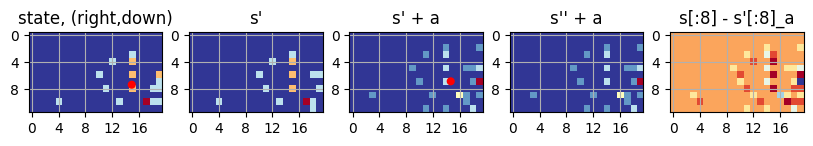

pre_center_coor: [ 7.         14.86666667] curr_center_coor: [ 6.61538462 13.76923077]
frame_angle:  340.68610538280734
action_angle:  45 up,right
Reward:  2


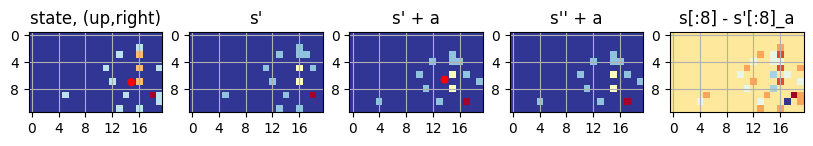

pre_center_coor: [ 5.85714286 12.        ] curr_center_coor: [7.         9.71428571]
frame_angle:  26.565051177077976
action_angle:  45 up,right
Reward:  2


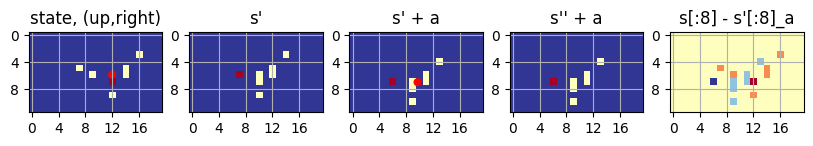

pre_center_coor: [ 6.         10.71428571] curr_center_coor: [5.5        8.66666667]
frame_angle:  346.27770286686643
action_angle:  0 right
Reward:  1


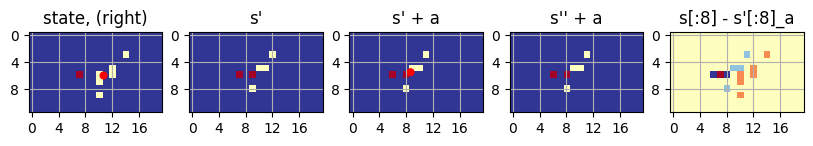

pre_center_coor: [ 5.5        10.66666667] curr_center_coor: [ 4.6 10.2]
frame_angle:  297.4075754378184
action_angle:  225 down,left
Reward:  2


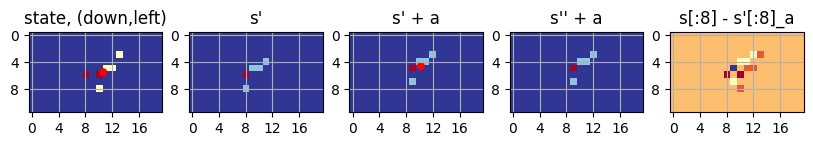

In [356]:
env = StarObserverEnv()
obs = env.reset()
print(obs.shape)

for i in range(5):
    
    action = random.randint(0,8)
    next_state, reward, done, info = env.step(action)
    print("Reward: ", reward)
    if done:
        print("done!!")
        break        
    env.render()
    


In [ ]:
## episod 종류가 여러개이고 전부 보여줘야함
## 전체 데이터에서 넘버링 배열을 통해서 시작 지점 끝점까지 일부분만 들고오게함 
## 배열을 여러개 만듬 
## 나중에 기워 붙일것도 생각하긴 해야함 mask rcnn 에서 직접받으면 어떻게되는지 고려할것

##  start ~ end 까지 시나리오 돈다고 가정 중간 중간에 start 와 done 넘버가 있는 2차원 배열을 받음 36.npy 형태로 읽는다고 생각함

##  일단은 replay 단위로 순서대로 한다고 생각하고 코드구성

#  reset의 역할이 2개 필요함 다음  episod 로 넘기기와 replay 기록 넘기기

class view_envirement:
    def __init__(self):
        self.reward_threshold = 0 #  나중에 생각
        self.action_log = [] # state t기준 [action_t-3, action_t-2, action_t-1, action_t-1]
        self.view_point_log = [] # state t기준 [view_point_t-3, view_point_t-2, view_point_t-1, view_point_t-1]
        self.full_vpx_vpy_log = []
        #npy로 읽어올거임 추후 수정
        self.event_point = np.array([[36, 2250, 2349]])#np.load('./episods/episods.npy').astype(np.int16) #replay_number, start_frame, end_frame 
        
        self.pennFudanDataset_base_path = "../../result" 
        self.viewDataset_base_path = "./numpy_vpx_vpy"
        
        self.pennFudan_dataset_dict = {}
        self.view_point_dataset_dict = {}
        
        self.replay_list = list(map(int, os.listdir(self.pennFudanDataset_base_path)))
        print(self.replay_list)
        self.replay_number = 0
        self.start_frame = 0
        self.end_frame = 0
        
        ## 나중에 제거
        self.total_angle = []

        
        # replay 별로 dataset 구성 
        for replay_number in self.replay_list:
            #PennFudanDataset
            pennFudan_path = os.path.join(self.pennFudanDataset_base_path, str(replay_number)) 
            self.pennFudan_dataset_dict[replay_number] = PennFudanDataset(pennFudan_path, get_transform(train=False), window_size=4)

            #ViewPointDataset
            view_path = os.path.join(self.viewDataset_base_path,str(replay_number) )
            self.view_point_dataset_dict[replay_number] = ViewPointDataset(view_path, window_size=4)
        
        self.check_step = 0
        
        self.current_state = [] # torch (36,20,12)
        self.current_vpx = 0 # (128,128)
        self.current_vpy = 0 # (128,128)
        
        self.action_vpx = [1, 1, 0, -1, -1, -1, 0, +1, 0] # 우, 우상, 상, 좌상, 좌, 좌하, 하, 우하, 정지
        self.action_vpy = [0, -1, -1, -1, 0, +1, +1, +1, 0] # 우, 우상, 상, 좌상, 좌, 좌하, 하, 우하, 정지 좌측 위가 0,0임
        
        self.start_frame_state =[] # (9,20,12) 
        
    def step(self,action): # action 은 tensor로 받음
        
        def get_angle(center_coordinate1, center_coordinate2):
            y1, x1 = center_coordinate1
            y2, x2 = center_coordinate2
            degrees = math.degrees(math.atan2(y2-y1, x2-x1))
            
            if degrees < 0: # 0~ 180 ~ 0 ~ -180 -> 0 ~ 360
                degrees = 360-abs(degrees)
            
            return degrees
        
        def find_center_coordinate(frame):
            frame = torch.sum(frame,0)
            center_cordinate =  torch.nonzero(frame).sum(0).numpy() / len(torch.nonzero(frame)) # (y,x로 찍혀나옴)
            return center_cordinate
        
        # 동일 frame 에서 action을 생긴 state에 대해서 reward를 받기 next state에 대한 reward가 아님 
        
        #step은 0부터
        
        ## action
        
        ## action -> move view point
        action_idx = action.tolist()[0] # tensor([7]) -> [7] -> 7
        self.current_vpx += self.action_vpx[action_idx]
        self.current_vpy += self.action_vpy[action_idx]
        
        # 화면 밖으로 나가는거 방지 나중에 action masking 해줘야할듯
        if self.current_vpx < 0:
            self.current_vpx += 1
        if self.current_vpx > 107:
            self.current_vpx -= 1
        if self.current_vpy < 0:
            self.current_vpy += 1
        if self.current_vpy > 115:
            self.current_vpy -= 1
        #vpx_vpu log 기록
        self.full_vpx_vpy_log.append([self.current_vpx, self.current_vpy])
        ## action, view point  시간순대로 4개씩 기록해 놔야함
        if self.check_step > 3:
            #  action, view point 제거
            #state t기준 [action_t-3, action_t-2, action_t-1, action_t-1] -> [action_t-2, action_t-1, action_t, action_t]
            del self.action_log[0]
            del self.action_log[-1]
            del self.view_point_log[0]
            del self.view_point_log[-1]
            #  신규 action, veiw point  추가
            self.action_log.append(action_idx)
            self.action_log.append(action_idx)
            self.view_point_log.append([self.current_vpx, self.current_vpy])
            self.view_point_log.append([self.current_vpx, self.current_vpy])
        
        else:
            self.action_log = [ action_idx for _ in range(4)]
            self.view_point_log =([ [self.current_vpx, self.current_vpy] for _ in range(4)])
        
        ## done
        if  self.check_step >= self.end_frame - self.start_frame:   # 1~ 10 까지면 총 10번임 10번째에 done = True
            self.done = True
        else:
            self.done = False
         
        ##state
        pennFudan_dataset = self.pennFudan_dataset_dict[self.replay_number]
        view_point_dataset = self.view_point_dataset_dict[self.replay_number]
        
        if not self.done:
            pennFudan_data = pennFudan_dataset[self.start_frame + (self.check_step + 1) ][0] # [t-2,t-1,t, t+1]
            next_state = crop_view( pennFudan_data, self.view_point_log) # self.view_point_log.shape (4,2)
            
            frame_after_action = next_state[-18:-9] #(9,12,20) # frame t after action
        else:
            pennFudan_data = pennFudan_dataset[self.start_frame + (self.check_step)  ][0] # [t-3,t-2,t-1, t]
            
            frame_after_action = pennFudan_data[-9:] #(9,12,20) # frame t after action
            next_state = None
        ## reward
        reward = 0
            
        # 1. 초기 화면과의 유사도
    
        # 2, 초기화면과 유닛수 차이

        # 3.mask rcnn과 iou
        view_point_data = view_point_dataset[ self.start_frame + self.check_step ]
        Mask_RCNN_view_point = view_point_data[-1] # 장면이 4개라 1개만 꺼내옴

#         print(f'mask: {Mask_RCNN_view_point[0]}, {Mask_RCNN_view_point}')
#         print(f'model: {self.current_vpx},{self.current_vpy}')
        # x_min, y_min, x_max, y_max
        bbox1 = [Mask_RCNN_view_point[0],Mask_RCNN_view_point[1], Mask_RCNN_view_point[0]+20, Mask_RCNN_view_point[1]+12 ]
        bbox2 = [self.current_vpx, self.current_vpy, self.current_vpx +20, self.current_vpy +12 ]
        iou = bb_intersection_over_union(bbox1, bbox2 )
        
        if iou > 0.2:
            reward += 0 # 나중에 고쳐야함
            
        # 4.방향성 ( 위의 하드코딩 된곳 참조 )         #  건물 제거
        pre_frame_b_action = self.current_state[-18:-9] # action 하기 이전 frame t-1
        curr_frame_b_action = self.current_state[-9:] # action 하기 이전 frame t
        
        pre_frame_b_action = torch.cat( (pre_frame_b_action[:3],pre_frame_b_action[4:7]), 0)
        curr_frame_b_action = torch.cat( (curr_frame_b_action[:3],curr_frame_b_action[4:7]), 0)
        
        pre_frame_center_coor = find_center_coordinate(pre_frame_b_action)
        curr_frame_center_coor = find_center_coordinate(curr_frame_b_action)
        
        #angle
        angle = get_angle(pre_frame_center_coor, curr_frame_center_coor)
        
        #  객체가 하나도 안잡히면 angle이 nan이 나옴
        if np.isnan(angle):
            angle = 0
        self.total_angle.append(angle)    
        
        angle_reward = 0

        # 우, 우상, 상, 좌상, 좌, 좌하, 하, 우하, 정지 순임
        
        if angle == 0 and action_idx == 8:
            angle_reward += 2
        elif (action_idx*45 - 22.5) <= angle and angle < (action_idx*45 + 22.5):
            angle_reward += 2
            
        print('step')
        print(angle)
        print(action_idx)
        print(f'reward: {angle_reward}')
        reward += angle_reward
#         print(f'angle: {angle}')
#         print(action_idx)
#         print(reward)
            
        # 모든 작업 후에 step + 1
        self.check_step +=1
        self.current_state = next_state  # torch(36,12,20) 
        return next_state, reward, self.done, _ # done = True or false
        
    def reset(self):
        #  초기화
        self.check_step = 0
        self.done = False 
        self.full_vpx_vpy_log = []
        
        # random 하게 episoid 선택
        episod_num = np.random.randint(len(self.event_point ))
        self.replay_number , self.start_frame , self.end_frame = self.event_point[episod_num]
        
        
        ## get_initial_state
        pennFudan_dataset = self.pennFudan_dataset_dict[self.replay_number]
        view_point_dataset = self.view_point_dataset_dict[self.replay_number] 
        
        print(f'{self.replay_number} , {self.start_frame} , {self.end_frame}')
        pennFudan_data = pennFudan_dataset[self.start_frame][0]        # 0번이 image_data 1번은 정답 data
        view_point_data = view_point_dataset[self.start_frame]
        
        self.current_vpx = int(view_point_data[-1][0]) # (128,128)
        self.current_vpy = int(view_point_data[-1][1]) # (128,128)
        
        self.full_vpx_vpy_log.append([self.current_vpx, self.current_vpy])
        self.current_state = crop_view(pennFudan_data, view_point_data)
        
        #  reward에서 사용하기 위해서 저장
        self.start_frame_state = self.current_state[-9:] #(9,12,20)
        self.start_view_point = view_point_data[-1] # (2)
        return self.current_state  # torch(36,12,20)       

C:\Users\joo\.conda\envs\starcraft\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


1000 번째


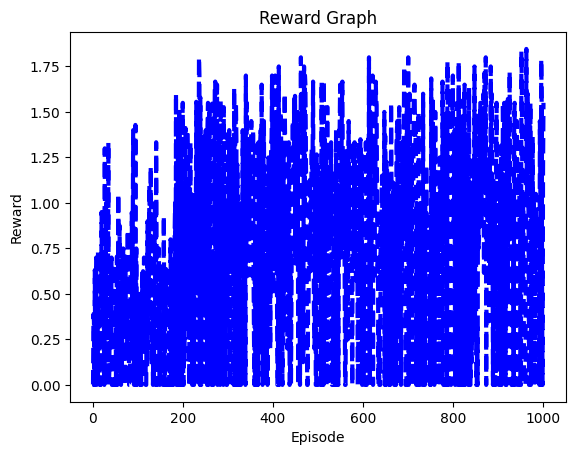

1000 번째  평균: 0.8016421899394036
2000 번째


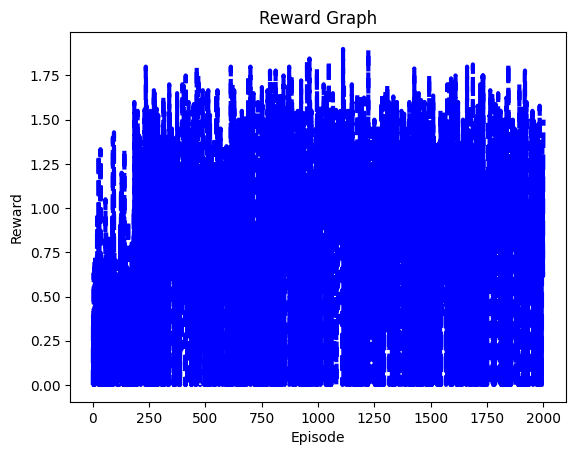

2000 번째  평균: 0.9343949003353028
3000 번째


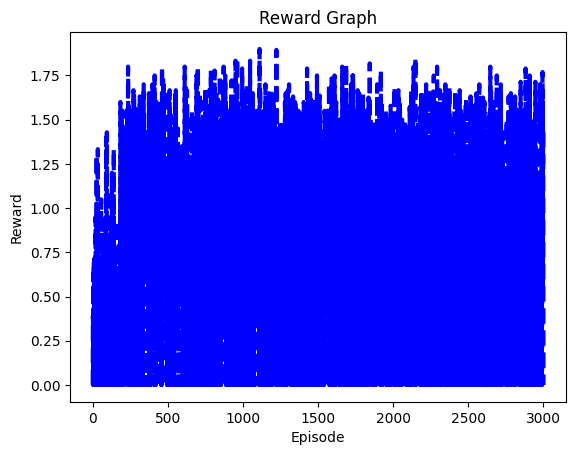

3000 번째  평균: 0.7986202686202686
4000 번째


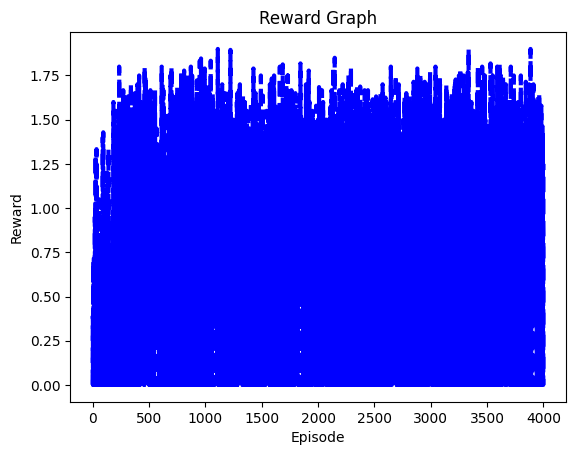

4000 번째  평균: 0.8977706203325398
5000 번째


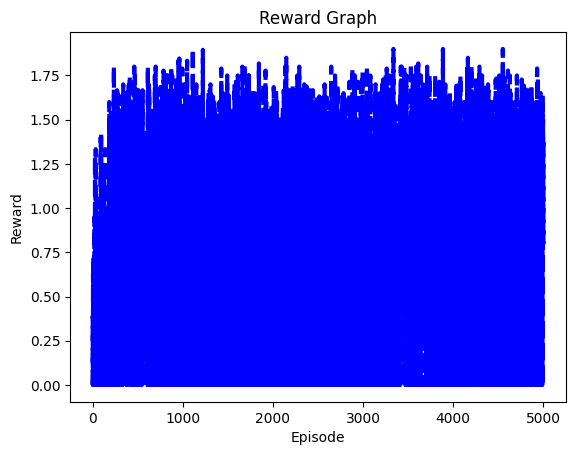

5000 번째  평균: 0.9696518284347231
6000 번째


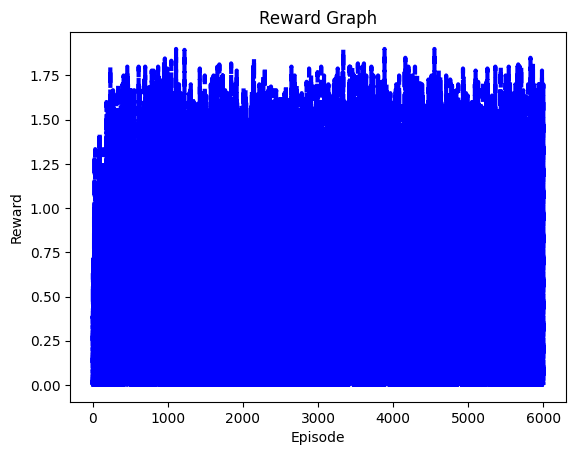

6000 번째  평균: 0.8443305378831696
7000 번째


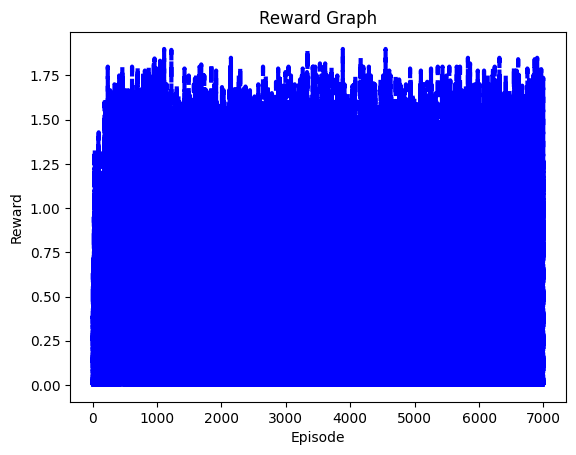

7000 번째  평균: 0.6551033946273884
8000 번째


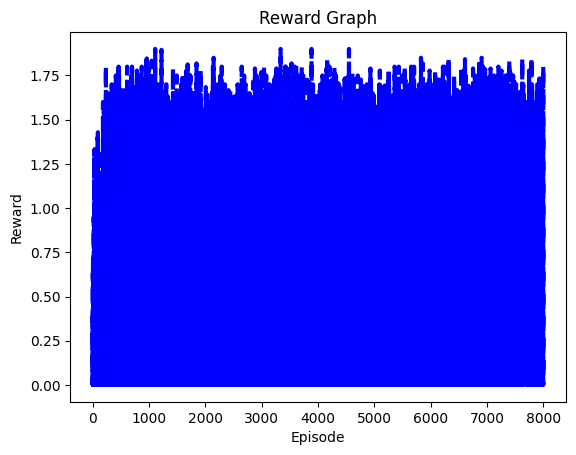

8000 번째  평균: 0.9445614035087722
9000 번째


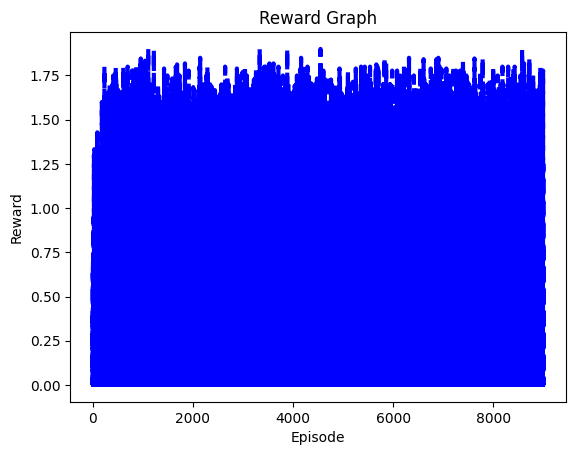

9000 번째  평균: 0.8073102542452387
10000 번째


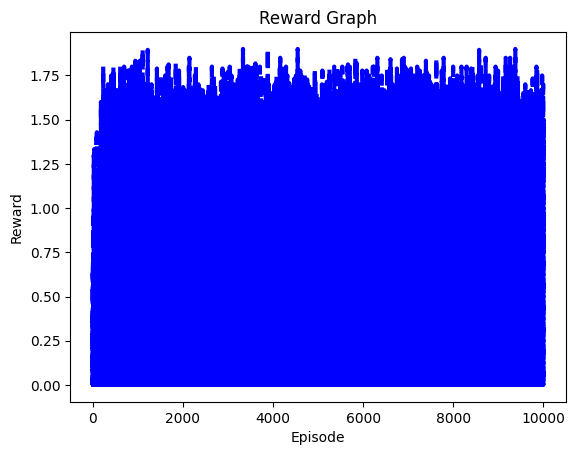

10000 번째  평균: 0.7410682957393483
11000 번째


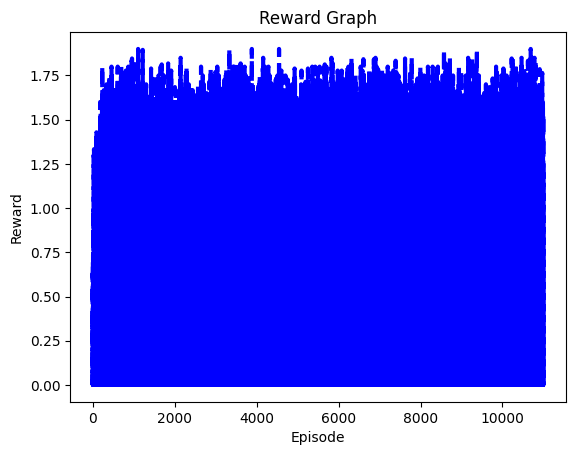

11000 번째  평균: 0.863331447963801
12000 번째


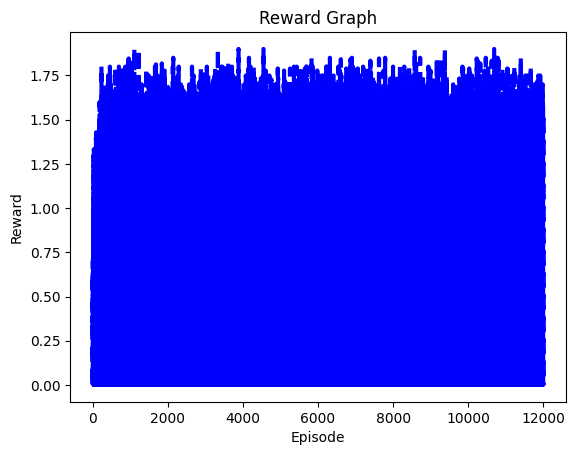

12000 번째  평균: 1.0285565741448095
13000 번째


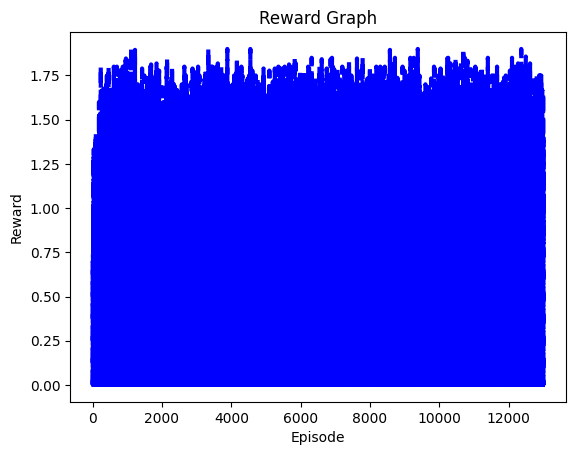

13000 번째  평균: 0.857483660130719
14000 번째


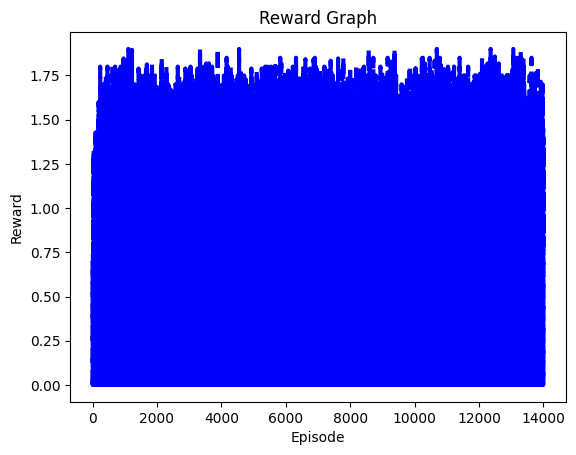

14000 번째  평균: 0.79654999820441
15000 번째


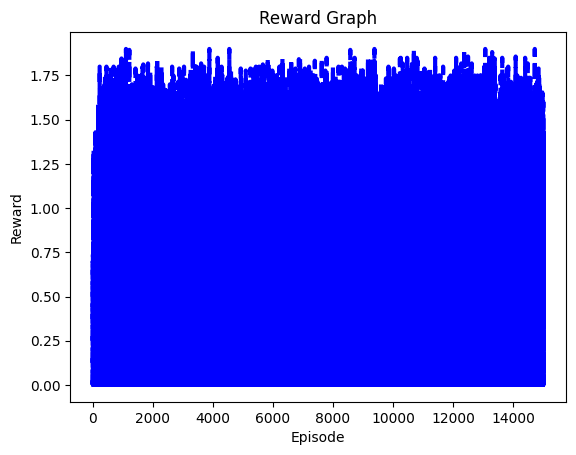

15000 번째  평균: 0.7489164673046251
16000 번째


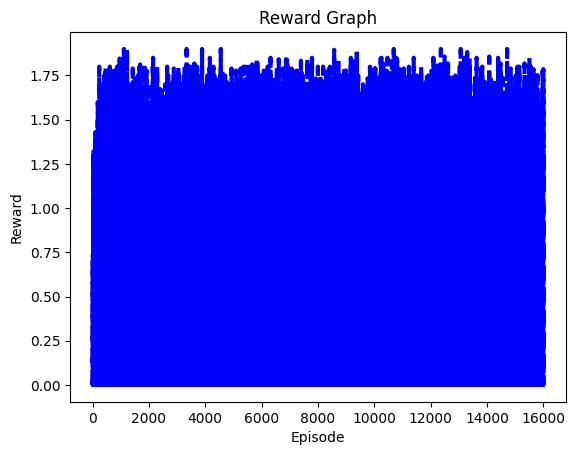

16000 번째  평균: 0.7003604599734631
17000 번째


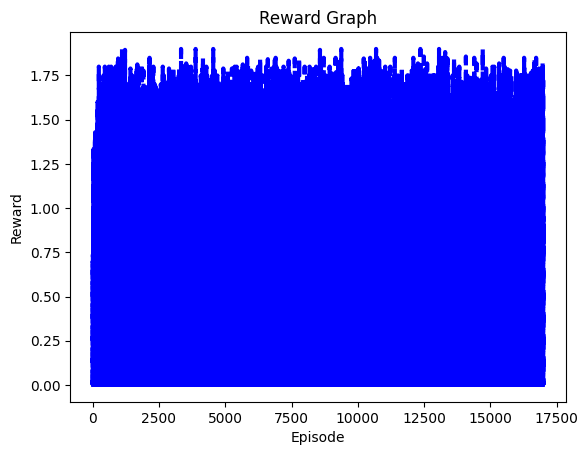

17000 번째  평균: 0.6461988304093567
18000 번째


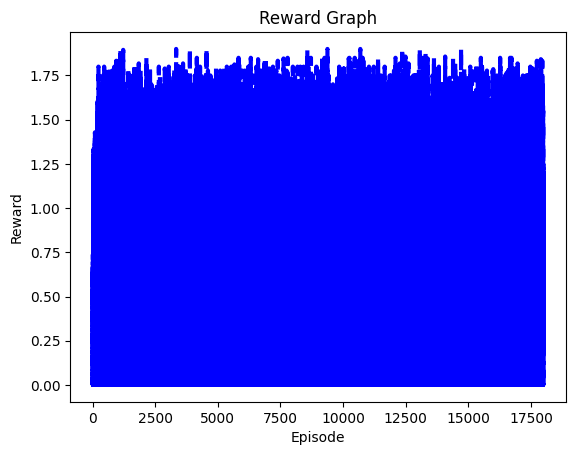

18000 번째  평균: 0.6543903026797764
19000 번째


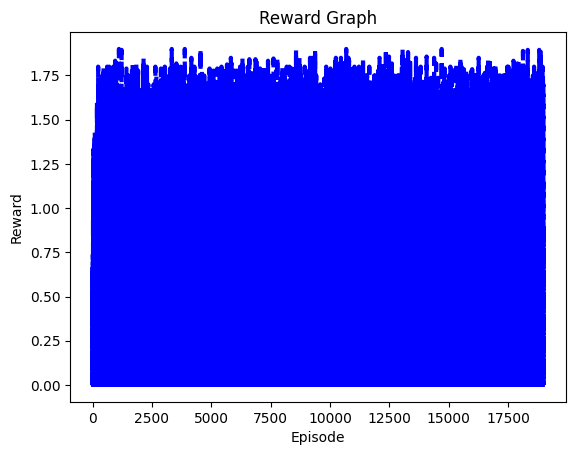

19000 번째  평균: 0.7245864661654136
20000 번째


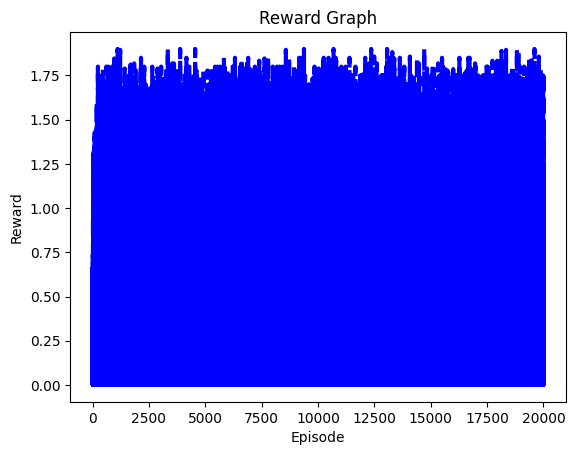

20000 번째  평균: 0.7884314954051796
21000 번째


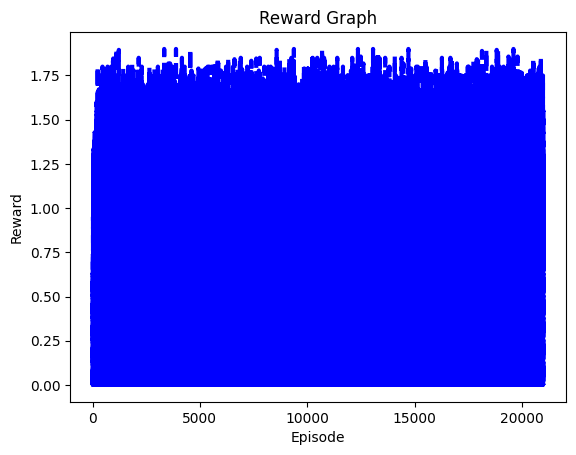

21000 번째  평균: 0.7830059523809524
22000 번째


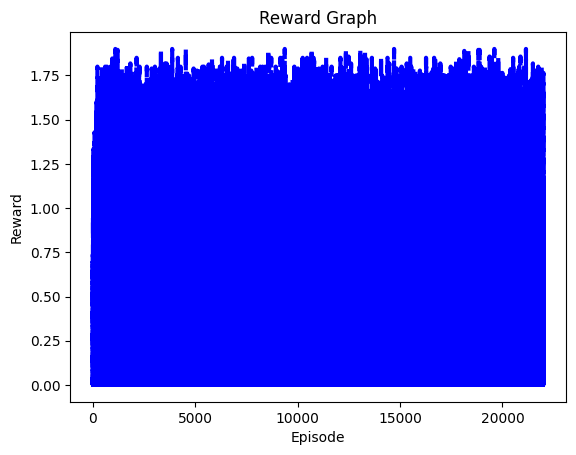

22000 번째  평균: 0.7187119008442537
23000 번째


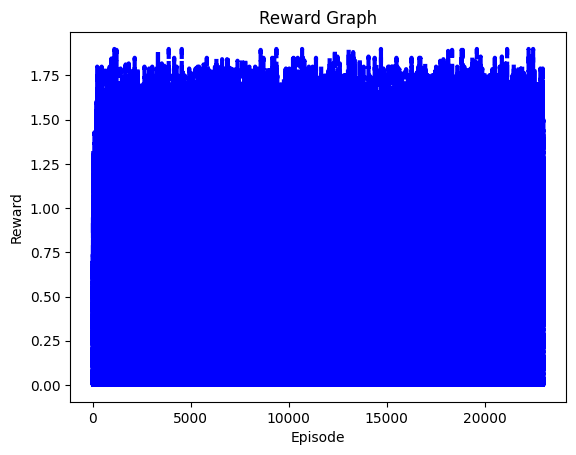

23000 번째  평균: 0.6699435432988066
24000 번째


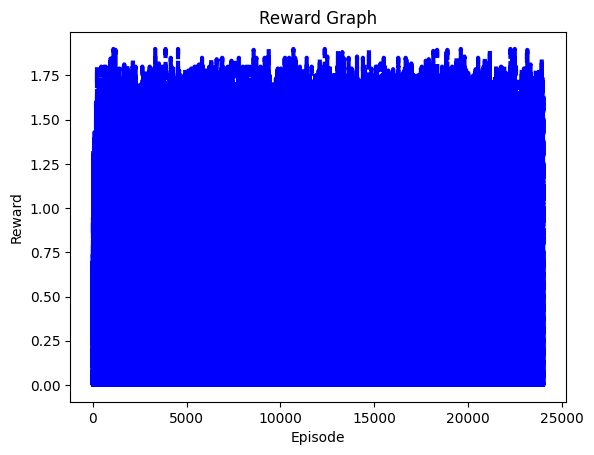

24000 번째  평균: 0.5169780219780219
25000 번째


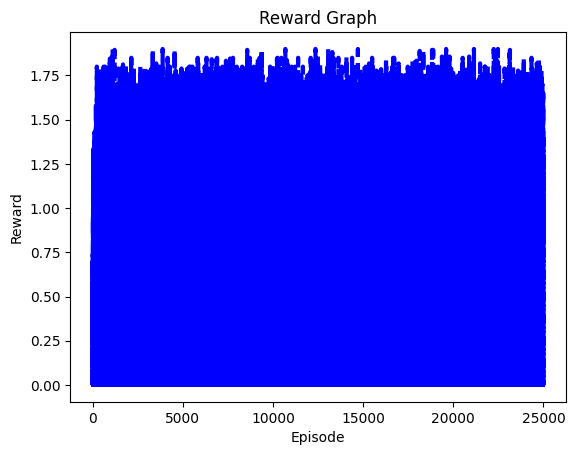

25000 번째  평균: 0.759465811965812
26000 번째


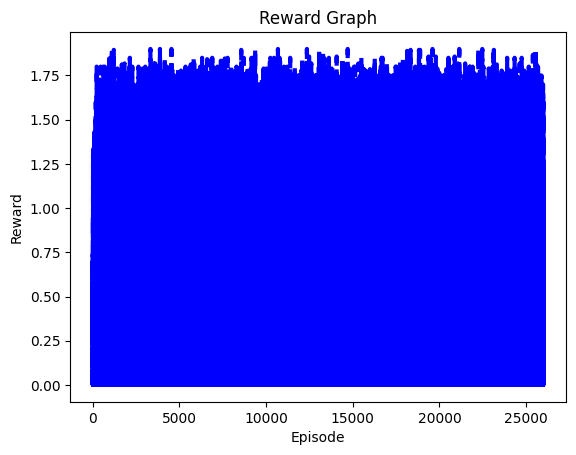

26000 번째  평균: 0.8774780701754388
27000 번째


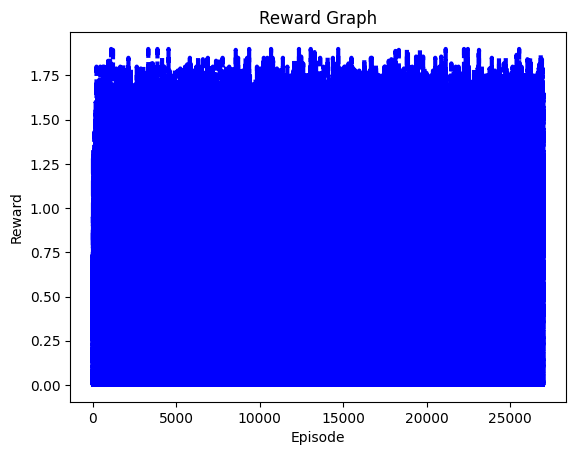

27000 번째  평균: 0.9566821774716511
28000 번째


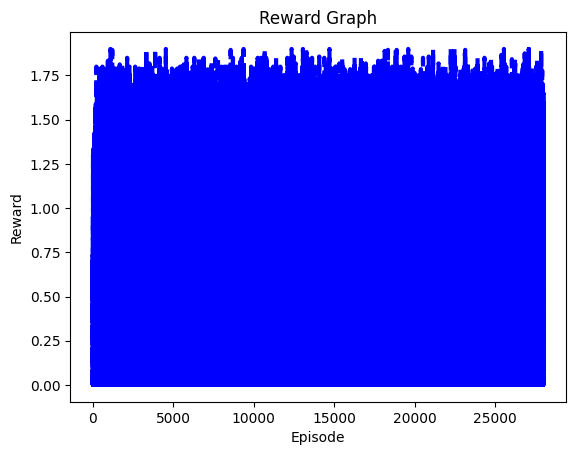

28000 번째  평균: 0.9448710010319917
29000 번째


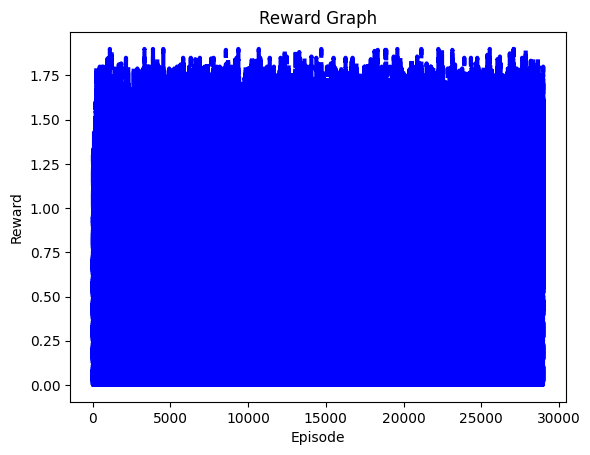

29000 번째  평균: 0.9571829366024414
30000 번째


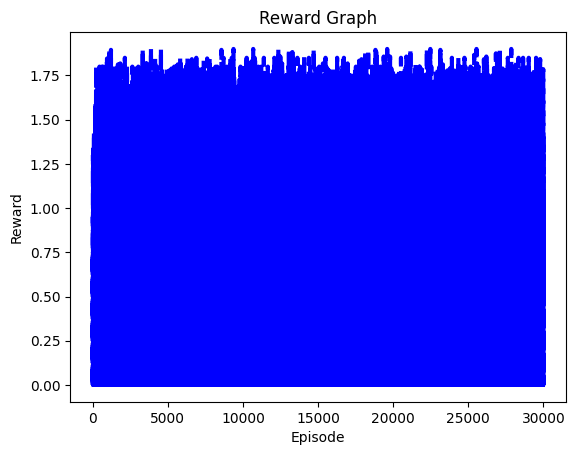

30000 번째  평균: 0.7912452086097597
31000 번째


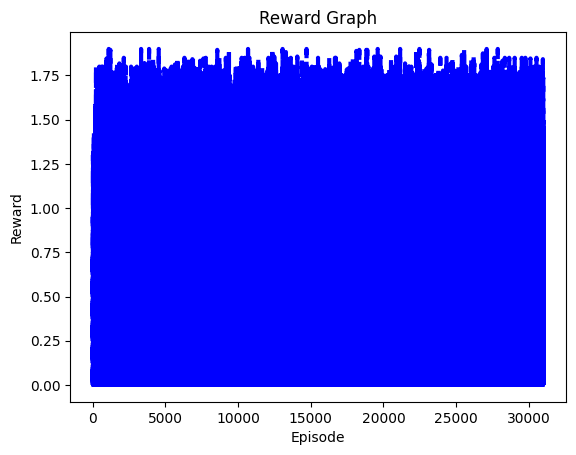

31000 번째  평균: 0.6951160990712074
32000 번째


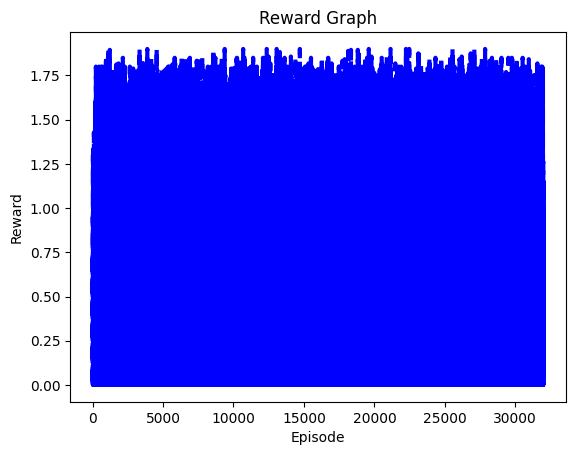

32000 번째  평균: 0.4870936811726286
33000 번째


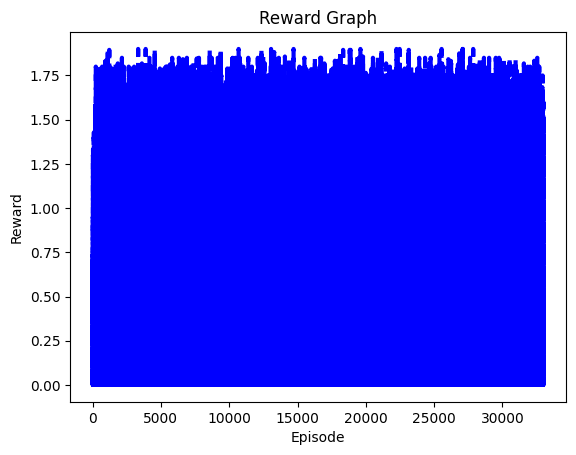

33000 번째  평균: 0.6946110681114551
34000 번째


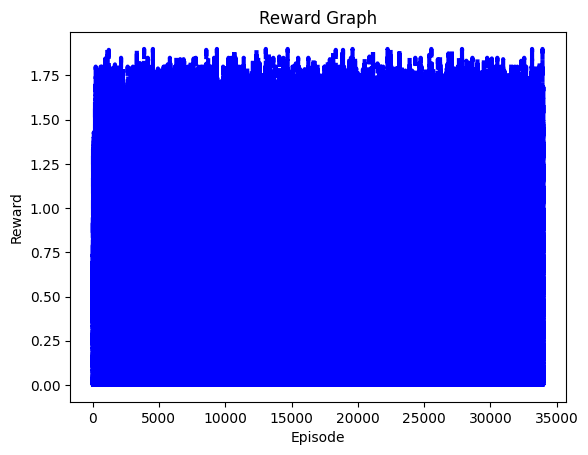

34000 번째  평균: 0.7272368421052631
35000 번째


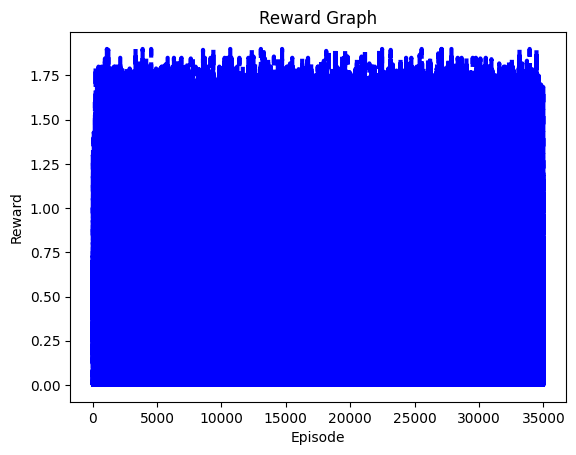

35000 번째  평균: 0.45011695906432747
36000 번째


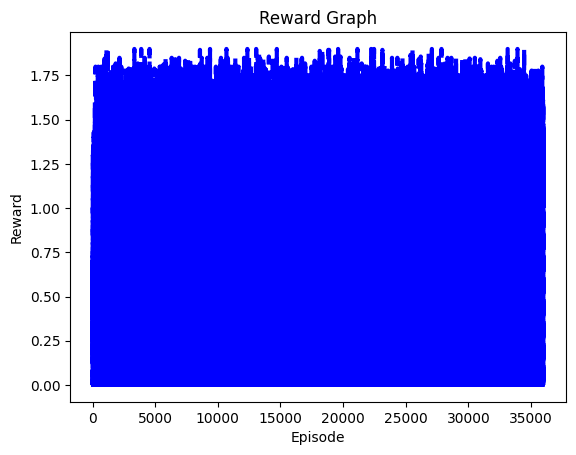

36000 번째  평균: 0.5966450345320314
37000 번째


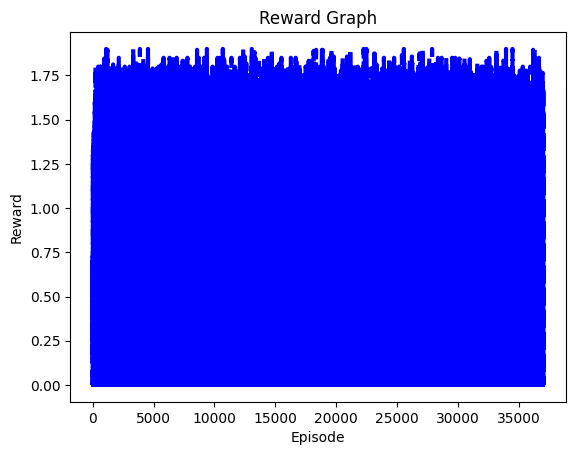

37000 번째  평균: 0.7781131750945992
38000 번째


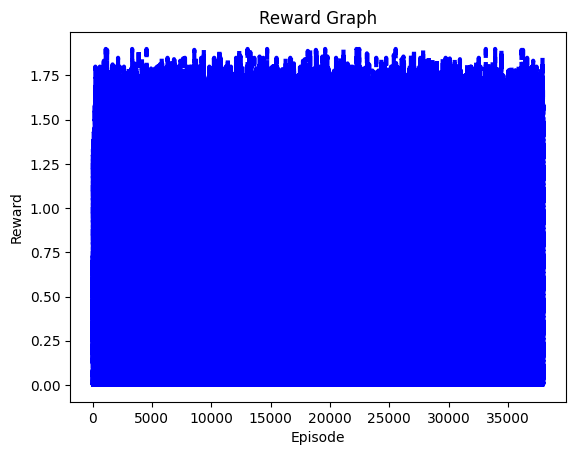

38000 번째  평균: 0.7026010101010102
39000 번째


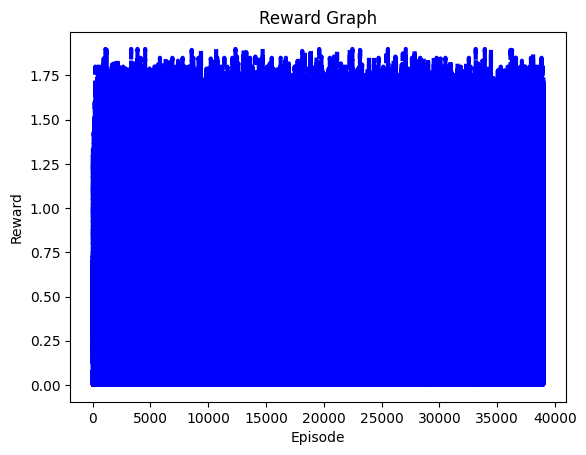

39000 번째  평균: 0.8189933166248956
40000 번째


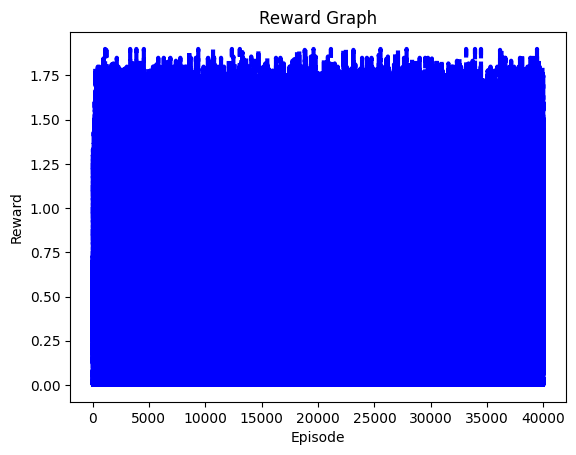

40000 번째  평균: 0.7214043522267206
41000 번째


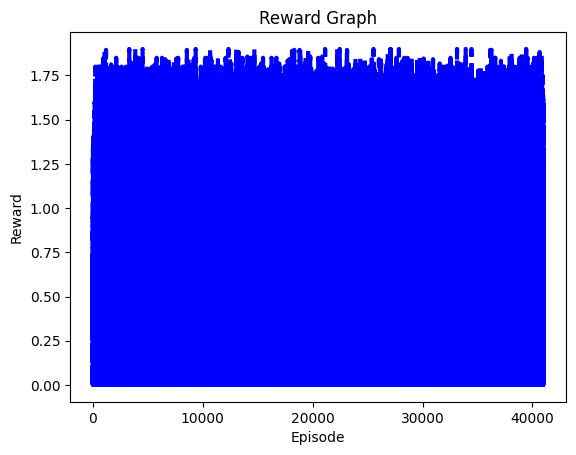

41000 번째  평균: 0.7755242272347534
42000 번째


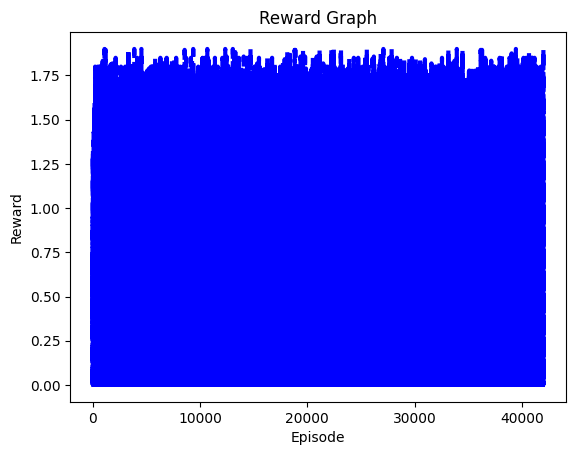

42000 번째  평균: 0.7306359649122808
43000 번째


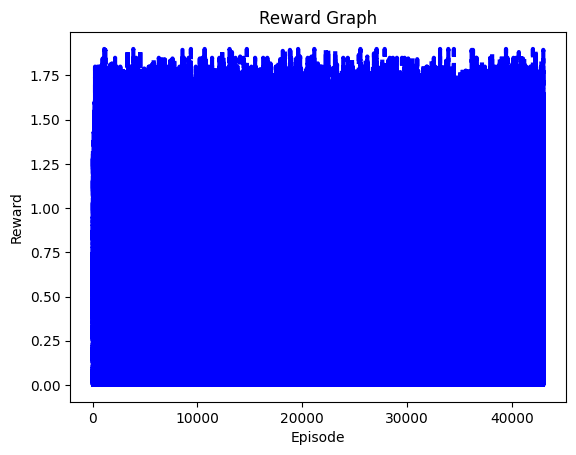

43000 번째  평균: 0.6826488569909622
44000 번째


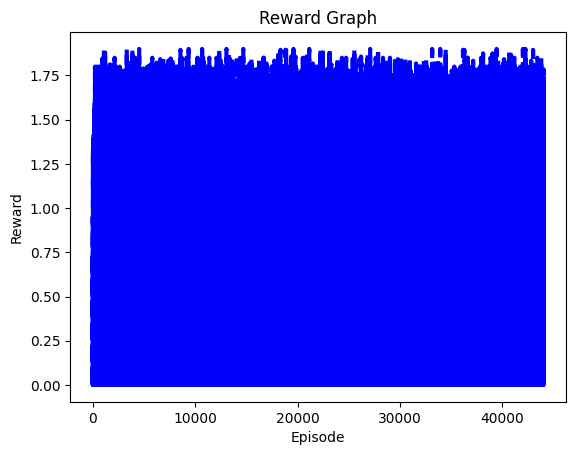

44000 번째  평균: 0.667977154424523
45000 번째


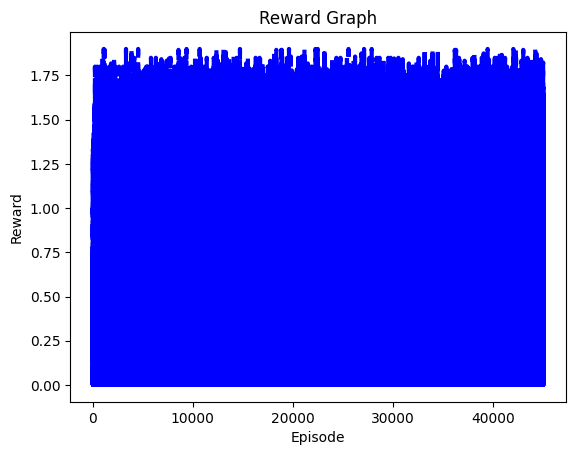

45000 번째  평균: 0.8644521229544451
46000 번째


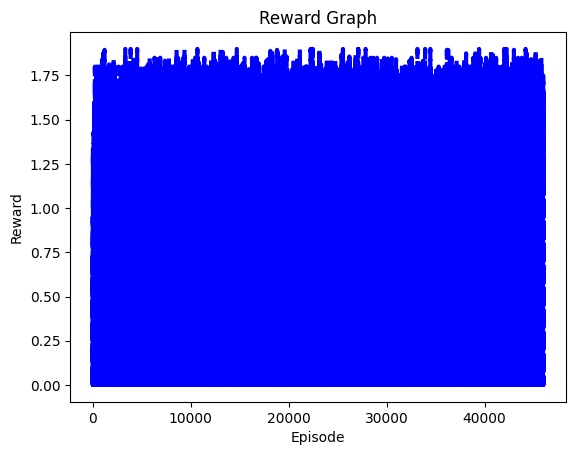

46000 번째  평균: 0.9800992063492064
47000 번째


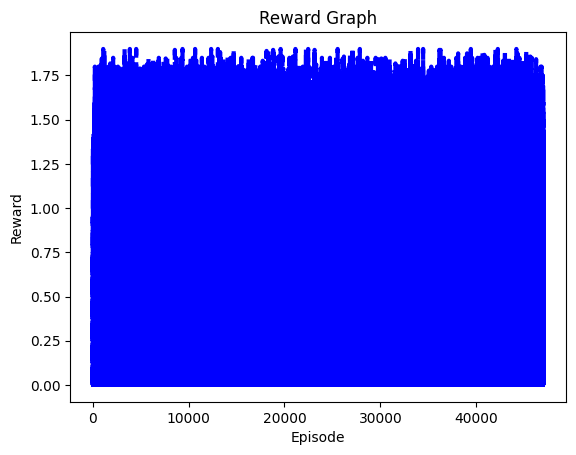

47000 번째  평균: 0.8773684210526316
48000 번째


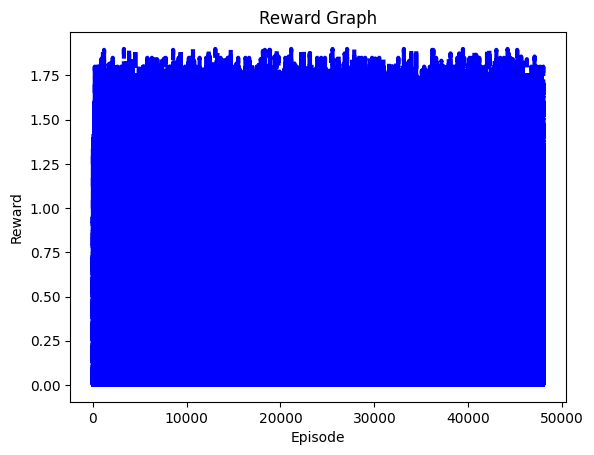

48000 번째  평균: 0.8616806220095695
49000 번째


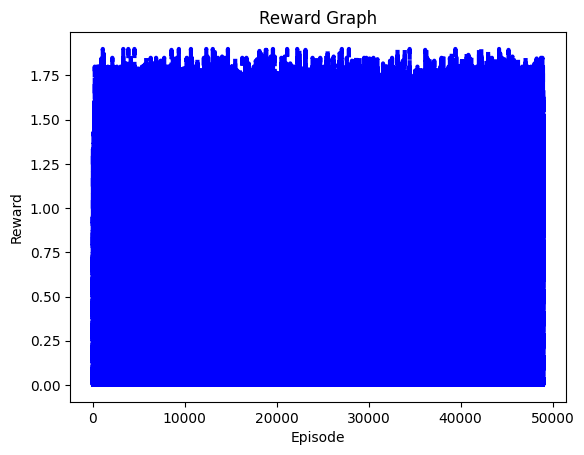

49000 번째  평균: 0.8204901960784314
50000 번째


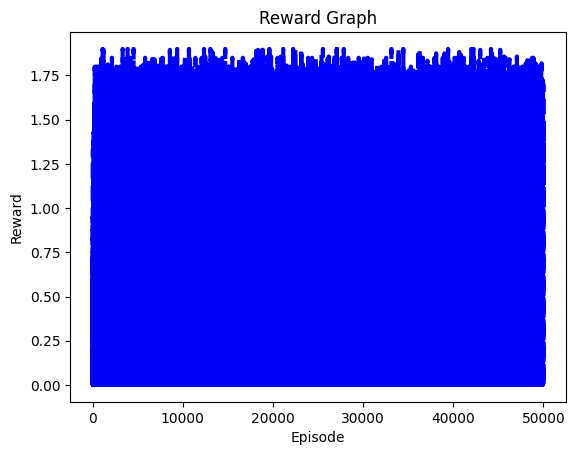

50000 번째  평균: 0.8594950115673801
51000 번째


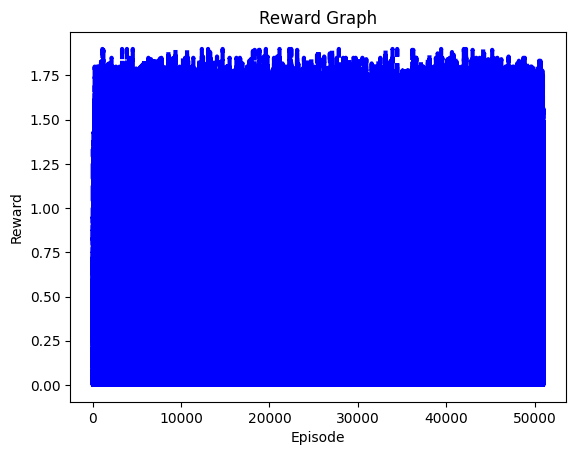

51000 번째  평균: 0.7452386173767753
52000 번째


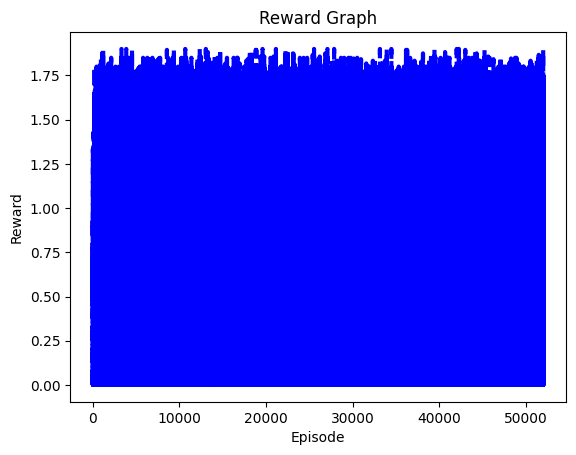

52000 번째  평균: 0.9013832793883104
53000 번째


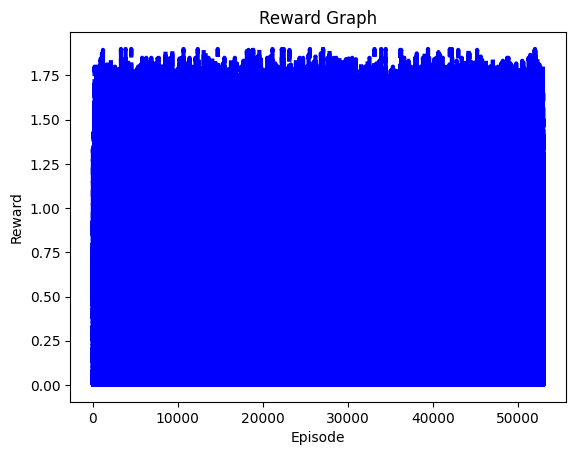

53000 번째  평균: 0.6760395473979066
54000 번째


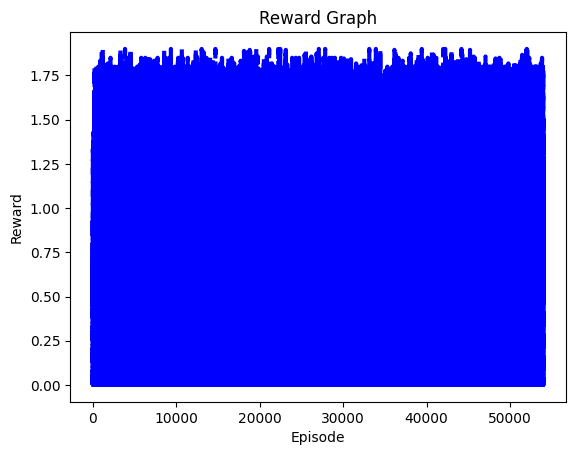

54000 번째  평균: 0.6608325738588896
55000 번째


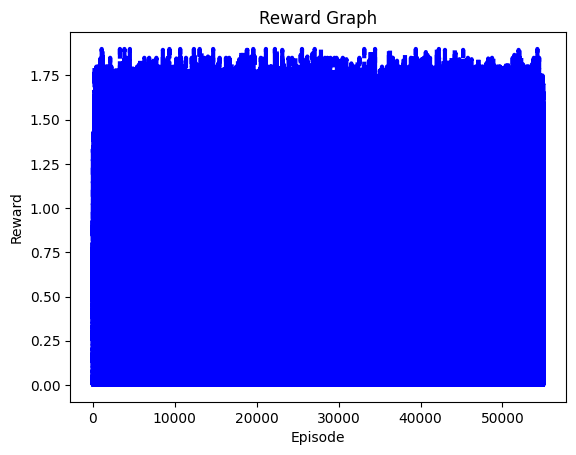

55000 번째  평균: 0.7617789666473878
56000 번째


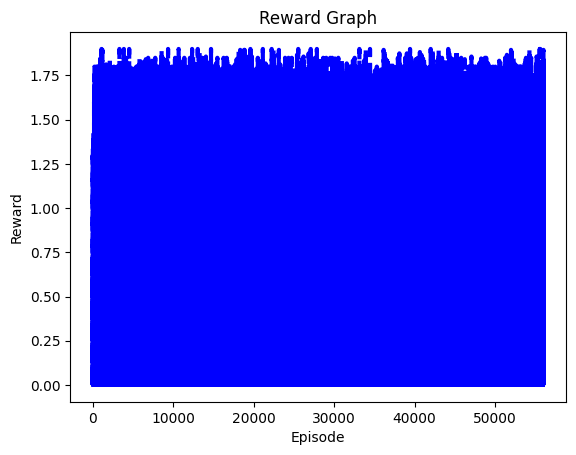

56000 번째  평균: 0.773640350877193
57000 번째


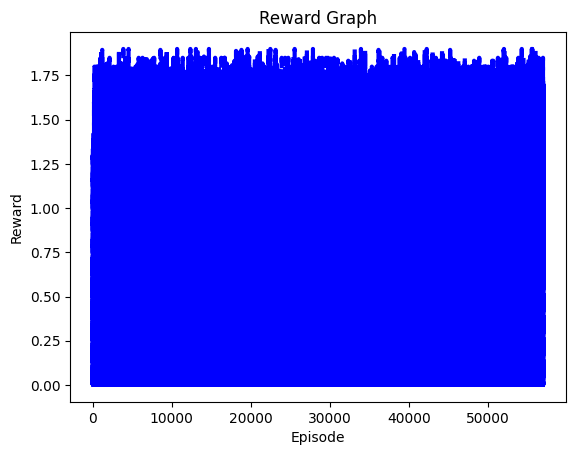

57000 번째  평균: 0.7523614758134882
58000 번째


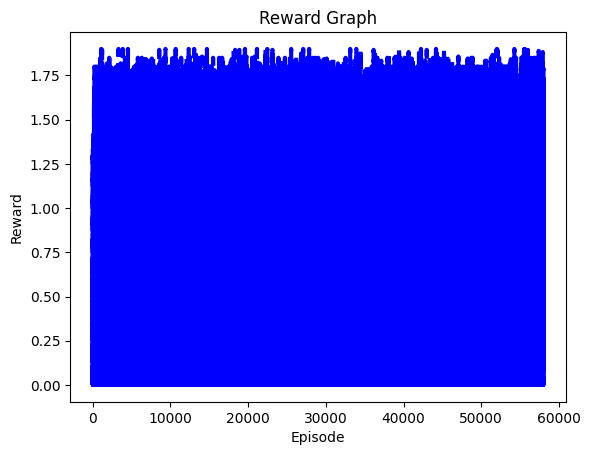

58000 번째  평균: 0.8525025799793603
59000 번째


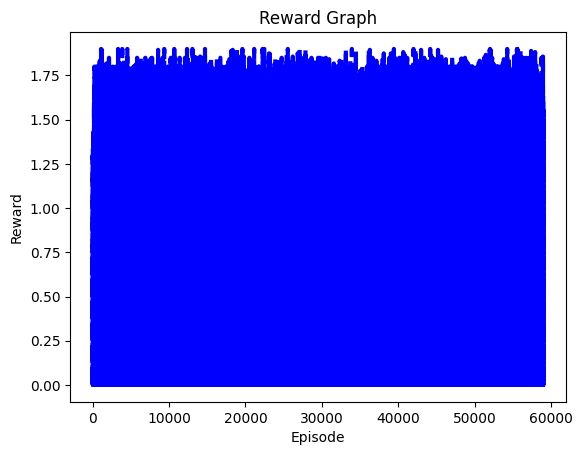

59000 번째  평균: 0.6611988304093568
60000 번째


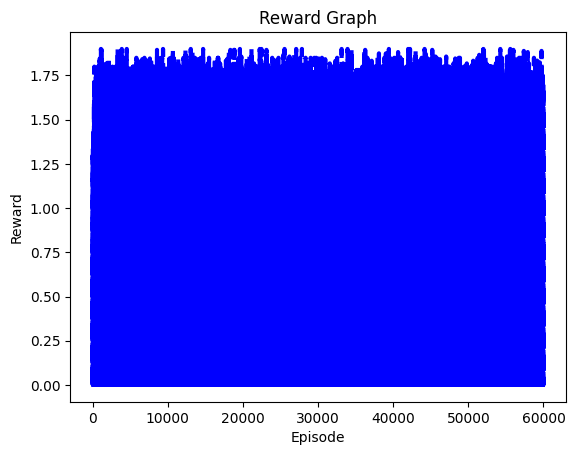

60000 번째  평균: 0.7585982277526395
61000 번째


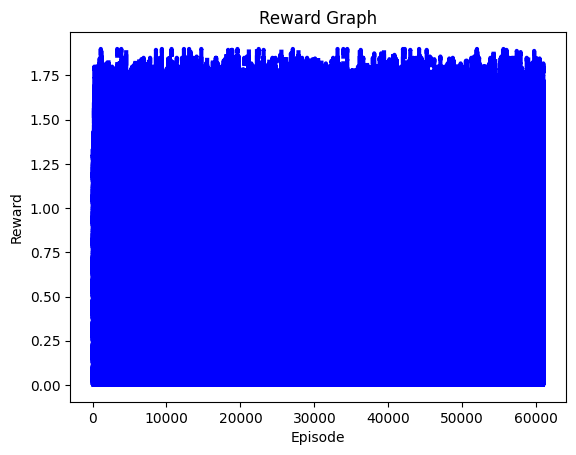

61000 번째  평균: 0.7433378482972136
62000 번째


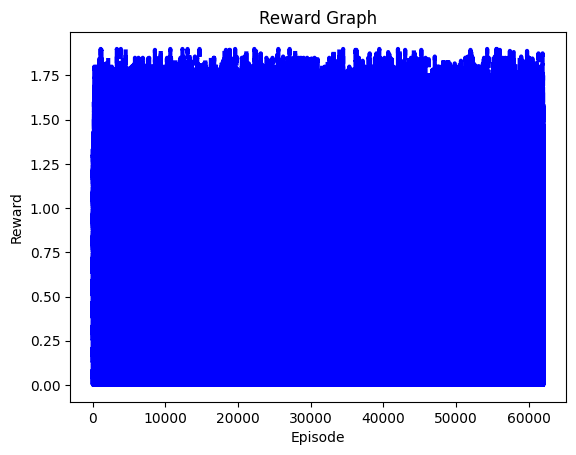

62000 번째  평균: 0.9644146423751685
63000 번째


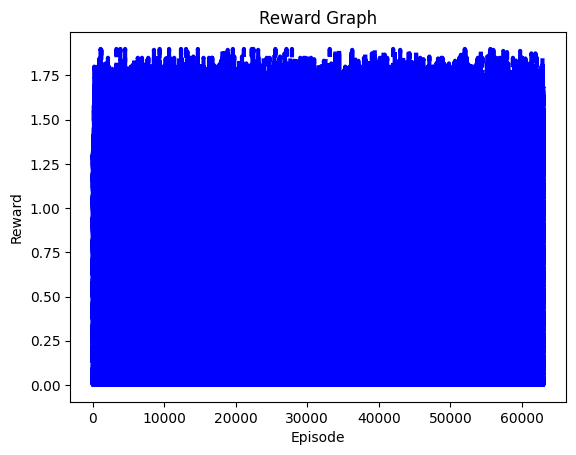

63000 번째  평균: 0.9182383040935672
64000 번째


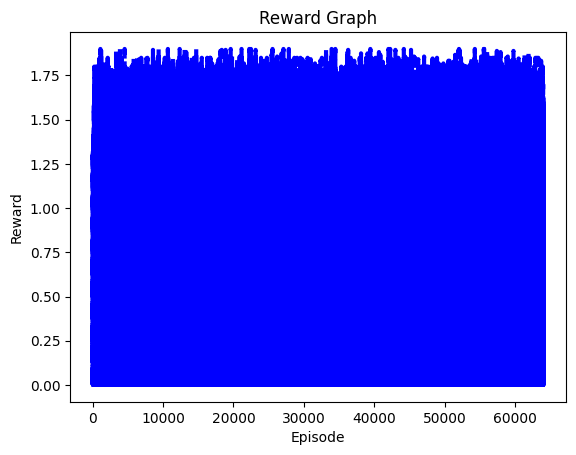

64000 번째  평균: 0.9753373015873015
65000 번째


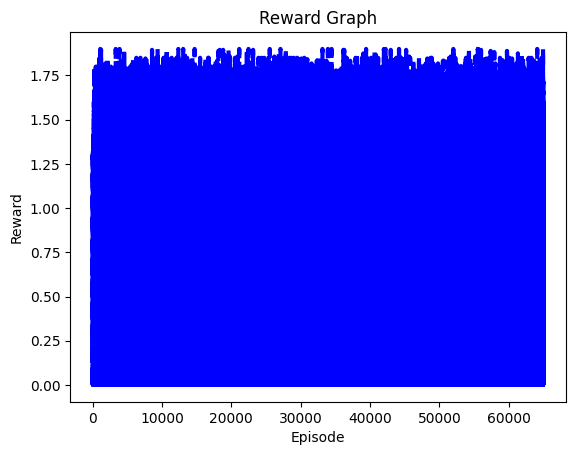

65000 번째  평균: 0.7834176349965823
66000 번째


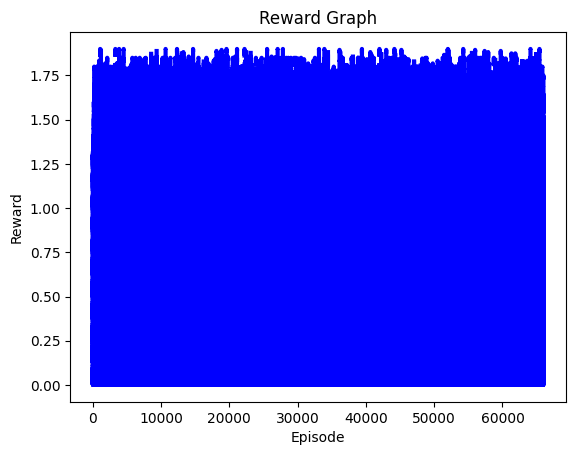

66000 번째  평균: 0.7454296799691537
67000 번째


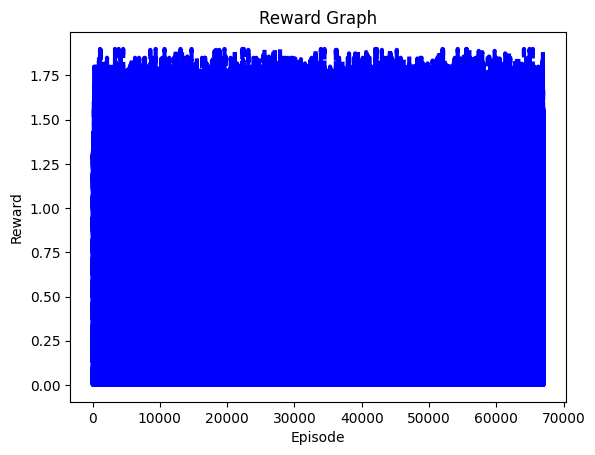

67000 번째  평균: 0.6734573613520982
68000 번째


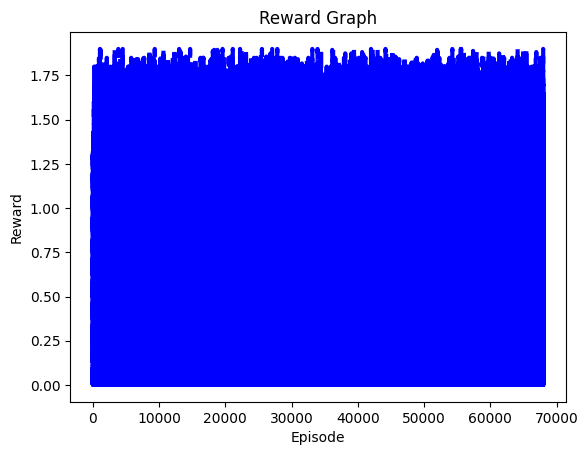

68000 번째  평균: 0.8506991744066047
69000 번째


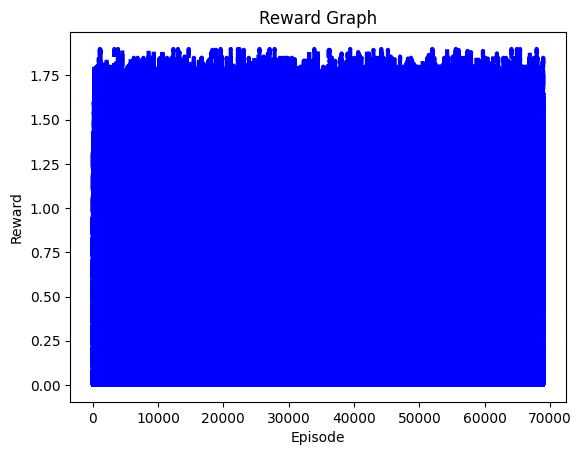

69000 번째  평균: 0.6375657894736843
70000 번째


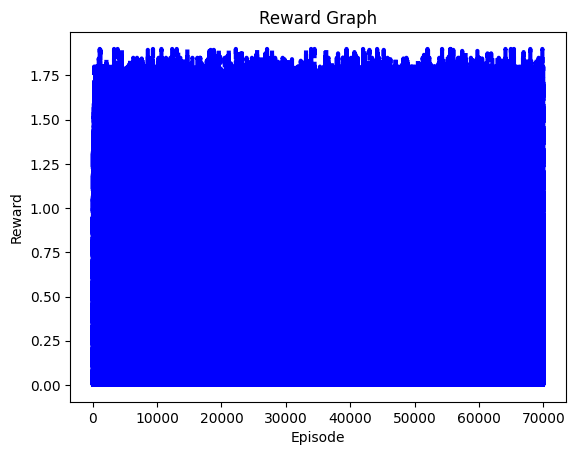

70000 번째  평균: 0.8944005847953218
71000 번째


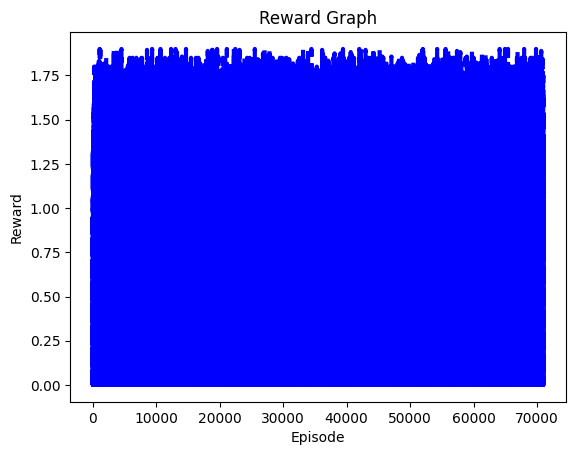

71000 번째  평균: 0.8971207406714374
72000 번째


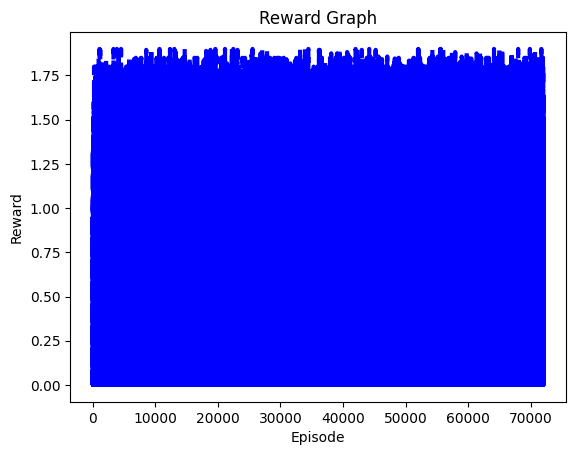

72000 번째  평균: 0.8774771682995366
73000 번째


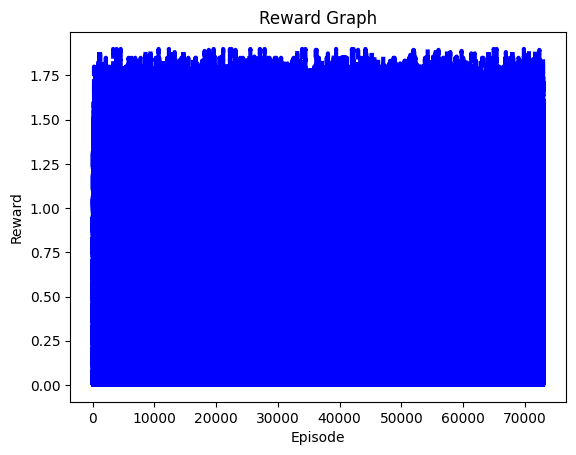

73000 번째  평균: 0.6284320175438596
74000 번째


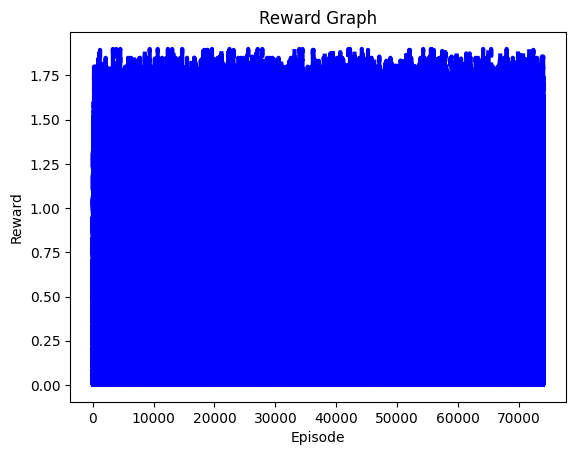

74000 번째  평균: 0.8311223316157527
75000 번째


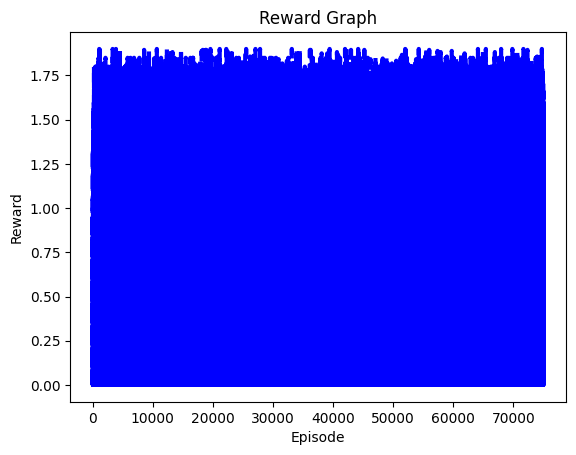

75000 번째  평균: 0.693531746031746
76000 번째


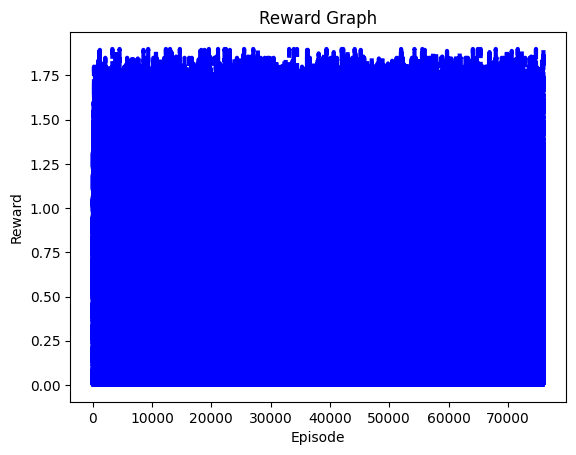

76000 번째  평균: 0.9375438596491229
77000 번째


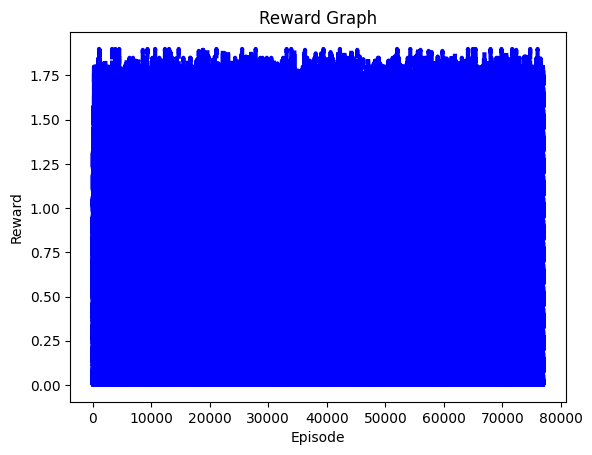

77000 번째  평균: 0.8585051169590644
78000 번째


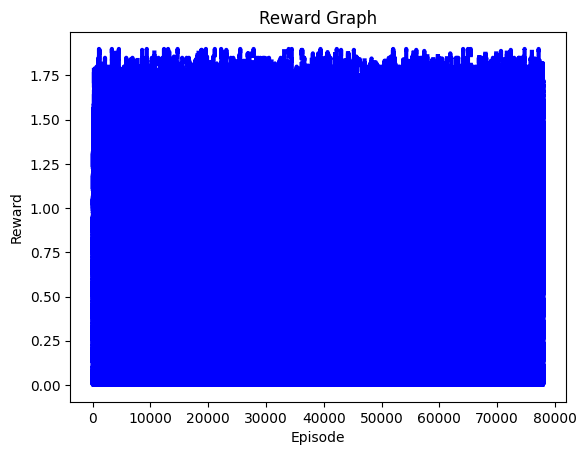

78000 번째  평균: 0.9835985797827902
79000 번째


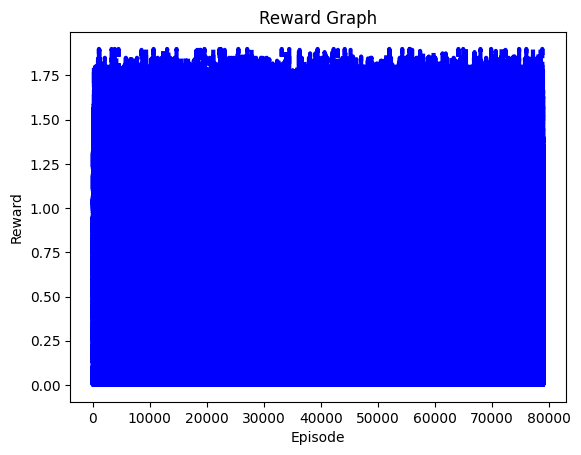

79000 번째  평균: 0.5654209146546608
80000 번째


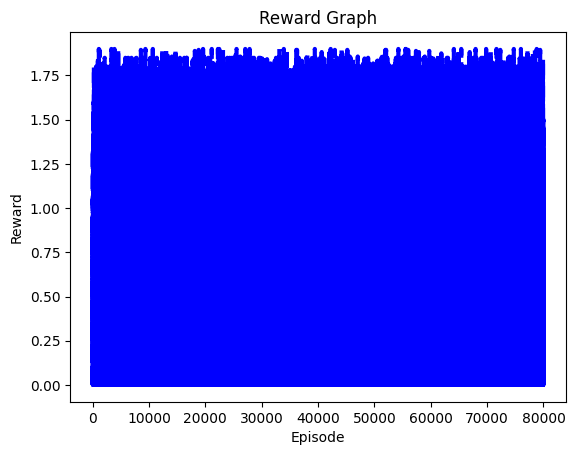

80000 번째  평균: 0.6578412413609782
81000 번째


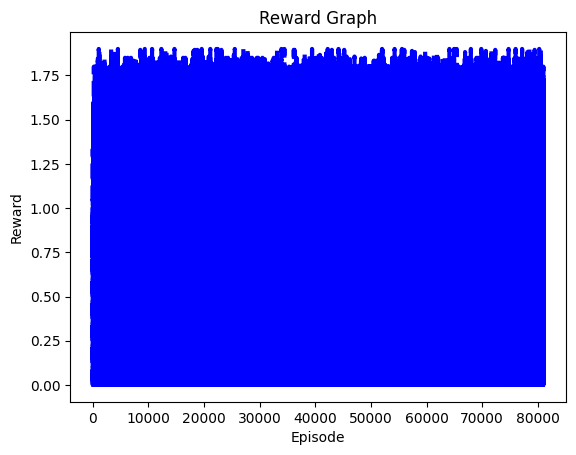

81000 번째  평균: 0.8110526315789472
82000 번째


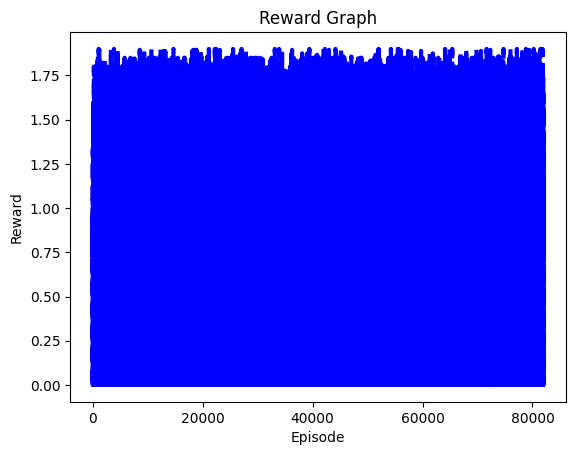

82000 번째  평균: 0.8588480392156864
83000 번째


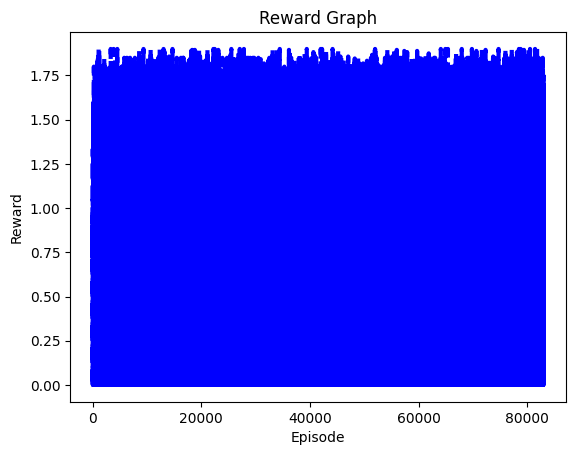

83000 번째  평균: 0.8829898610161768
84000 번째


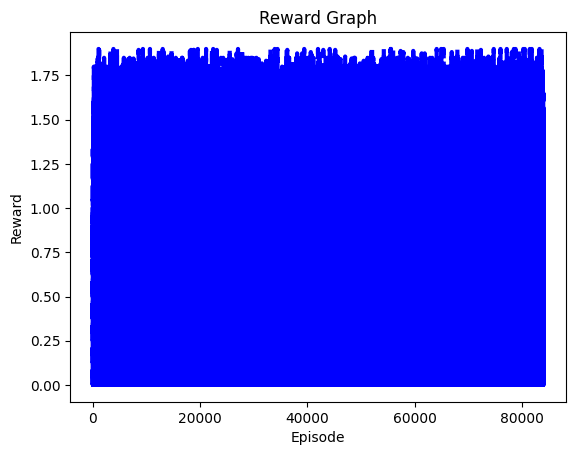

84000 번째  평균: 0.7310714285714285
85000 번째


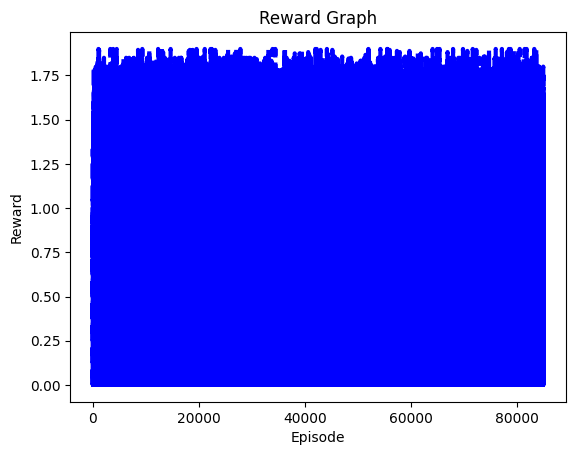

85000 번째  평균: 0.7249175824175824
86000 번째


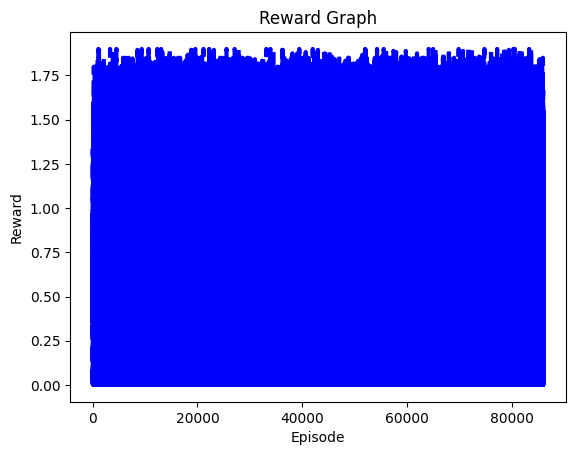

86000 번째  평균: 0.7667366946778712
87000 번째


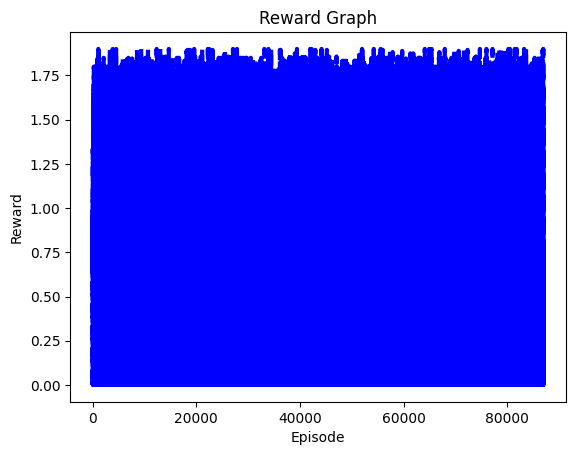

87000 번째  평균: 0.6945614035087719
88000 번째


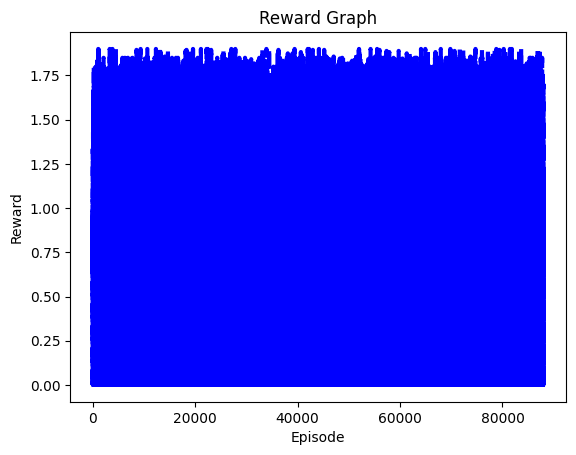

88000 번째  평균: 0.9371853932960745
89000 번째


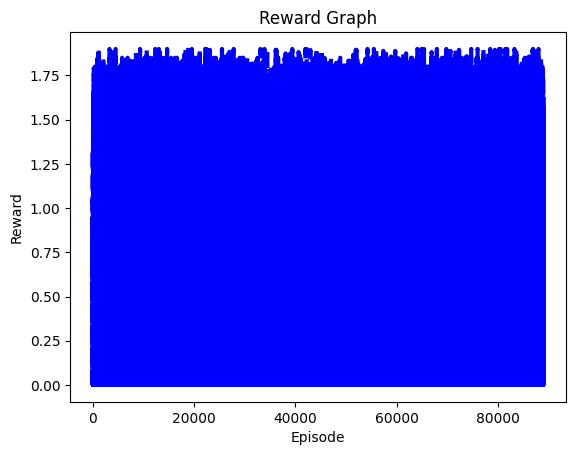

89000 번째  평균: 0.9683557610260396
90000 번째


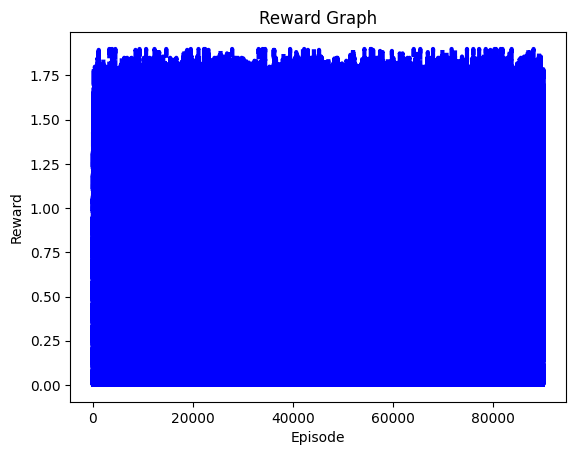

90000 번째  평균: 0.7727155846389592
91000 번째


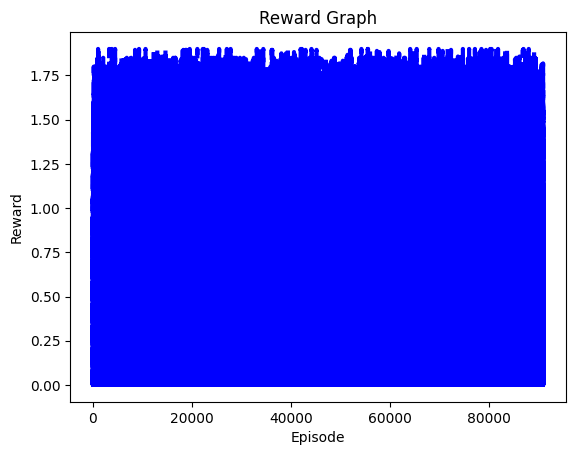

91000 번째  평균: 0.6710283060592659
92000 번째


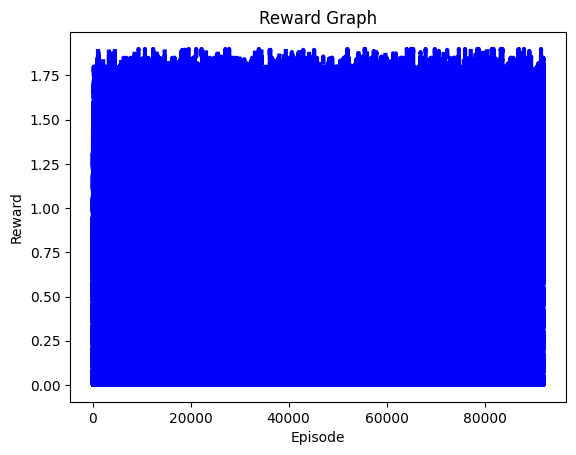

92000 번째  평균: 0.848397435897436
93000 번째


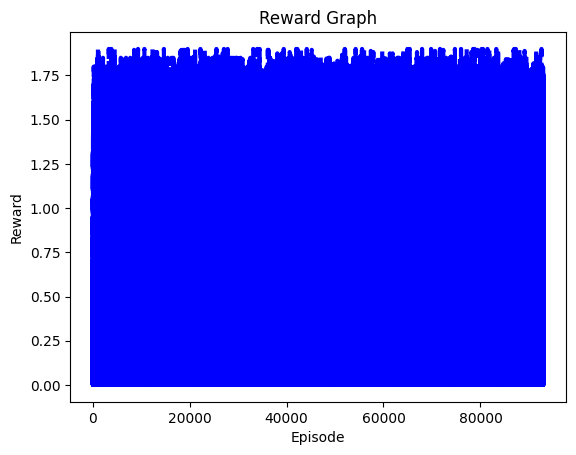

93000 번째  평균: 0.9735501508295625
94000 번째


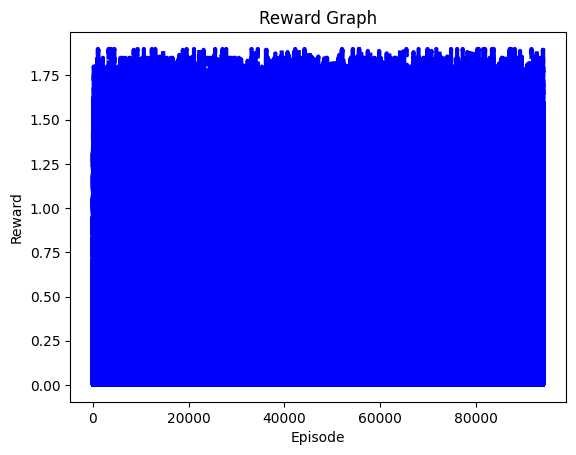

94000 번째  평균: 0.5551785714285714
95000 번째


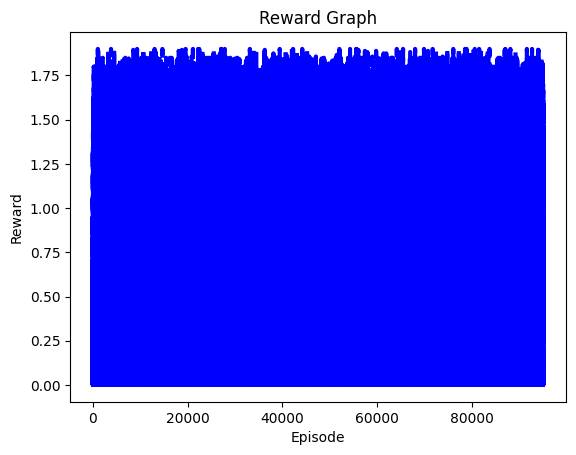

95000 번째  평균: 0.7190855609818458
96000 번째


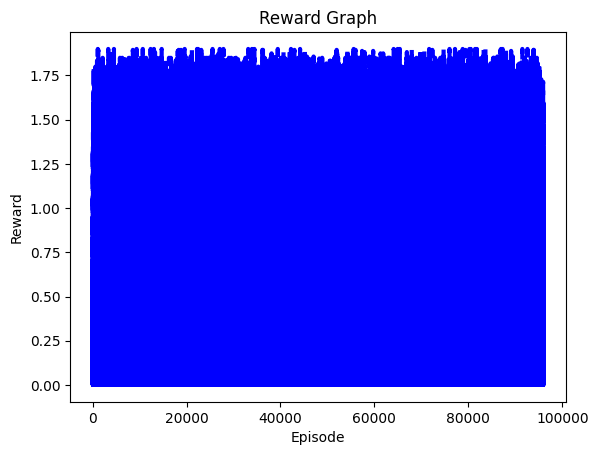

96000 번째  평균: 0.723859649122807
97000 번째


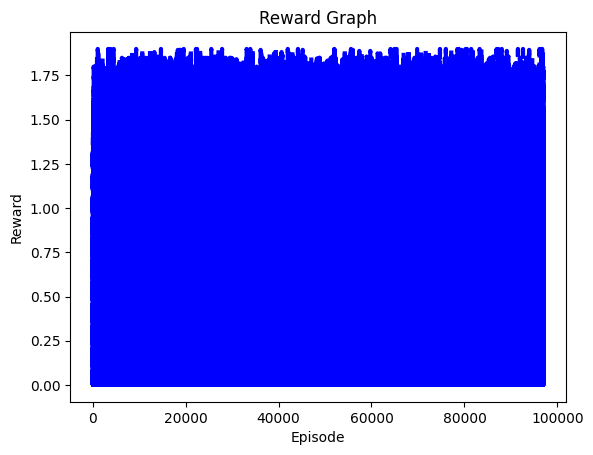

97000 번째  평균: 0.7615786062922285
98000 번째


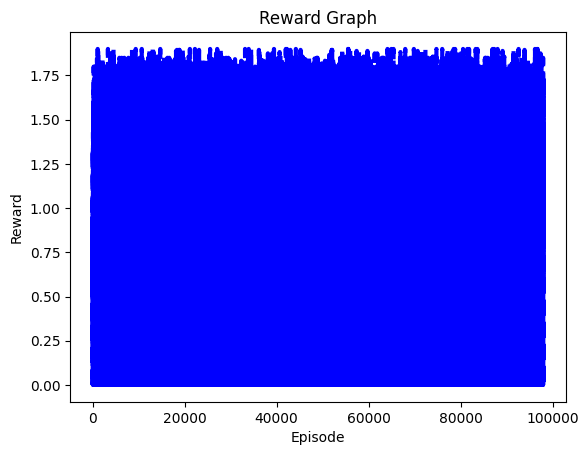

98000 번째  평균: 0.7823426212590299
99000 번째


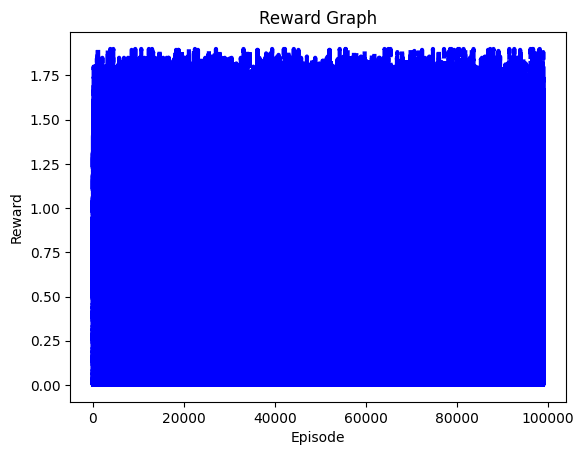

99000 번째  평균: 0.9093874108347793


In [230]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
from itertools import count
import matplotlib.pyplot as plt
from gym.envs.registration import register

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # exploration
GAMMA = 0.9                 # reward discount factor
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 5 #2000

N_ACTIONS = 9
N_STATES = (16,12,20)

env = StarObserverEnv()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(16, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(2048, 1)
        self.fc2 = nn.Linear(1, 9)
        
        #(64x32 and 2048x32)
        #1x2048 and 32x64
        
    def forward(self, x):      
        x = self.conv1(x)      
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)      
        x = self.dropout1(x)      
        x = torch.flatten(x, 1)      
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        #output = F.log_softmax(x, dim=1)
        return x #output

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.eval_net = Net()
        self.target_net =  Net()
        self.train_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory_counter2 = 0      
        self.memory = np.zeros((MEMORY_CAPACITY, 16 , 24 , 20))     # initialize memory
        self.memory2 = np.zeros((MEMORY_CAPACITY, 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)

    def select_action(self, x):
        x = x.float().unsqueeze(0)
        if np.random.uniform() < EPSILON:   # Exploration
            actions_value = self.eval_net.forward(x) # [[0.3, 0.9]]
            action = torch.max(actions_value, 1)[1].data.numpy() # 큰 값의 인덱스를 뽑아냄 [1], (0.9 > 0.3)
            action = action[0] # 1
        else:
            action = np.random.randint(0, N_ACTIONS)
        return action # 0과 1을 이용

    def replay_memory(self, s, a, r, s_):        
        transition = np.hstack((s, s_)) # 4, 1, 1, 4 = size(10)        
        transition2 = np.hstack((a, r)) # 4, 1, 1, 4 = size(10)
        index = self.memory_counter % MEMORY_CAPACITY # 2000step 마다 각각 메모리 갱신
        self.memory[index, :] = transition
        self.memory2[index, :] = transition2
        
        self.memory_counter += 1
        self.memory_counter2 += 1

    def train(self):
        # target parameter update
        if self.train_step_counter % TARGET_REPLACE_ITER == 0: # 100step 마다 eval_net -> target_network (복사)
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.train_step_counter += 1

        # batch 사이즈 만큼 transitions 을 뽑아냄.
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE) # 메모리에서 랜덤 샘플링 할 index 추출, 32
        memory_batch = self.memory[sample_index, :] # 메모리 추출, (32,10), 32:배치사이즈, 10: s(4),a(1),r(1),s(4)
        memory_batch2 = self.memory2[sample_index, :] # 메모리 추출, (32,10), 32:배치사이즈, 10: s(4),a(1),r(1),s(4)
        state_batch = torch.FloatTensor(memory_batch[:, :,:12, :]) # (32,4)
        action_batch = torch.LongTensor(memory_batch2[:,:1].astype(int)) # (32,1) : [[0],[1],[1],[0],....], (중의적으로 index의 의미를 가짐.)
        reward_batch = torch.FloatTensor(memory_batch2[:,1:]) # (32,1)
        next_state_batch = torch.FloatTensor(memory_batch[:,:, 12:,:]) # (32,4)

        # cost function        
        #print("train_state_shape",state_batch.shape)
        q_eval = self.eval_net(state_batch).gather(1, action_batch) # 실제 q값을 뽑아냄, [32,1], action batch(index)를 이용
        q_next = self.target_net(next_state_batch).detach() # detach : 훈련할 때, q_next는 backprob을 하지 않음
        q_target = reward_batch + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        loss = nn.MSELoss()(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

dqn = DQN()


def main():
    total_reward_list = []
    #for i_episode in count(1):
    for i_episode in range(100000):
        total_reward = 0
        state = env.reset() # 16, 12, 20
        for t in range(50):
            
            action = dqn.select_action(state)
            next_state, reward, done, info = env.step(action)
            
            if done :
                #print(total_reward)
                total_reward = total_reward/(t+1)
                total_reward_list.append(total_reward)
                total_reward = 0
                break
                
            total_reward += reward
            #print(reward) # 16, 12, 20
            #print(action) # 16, 12, 20            
            #print(np.shape(next_state))

            dqn.replay_memory(state, action, reward, next_state) # 매 step 마다 메모리에 저장 (s,a,r,s')

            #print(dqn.memory_counter)
            if dqn.memory_counter > MEMORY_CAPACITY: # 메모리가 2000이 다 채워졌을 때, train 시작 # frameskip은 내장되어 있음.
                #total_reward = 0 
                dqn.train()
                if done:
                    total_reward = total_reward/(t+1)
                    total_reward_list.append(total_reward)
                    #total_reward=0
                    break

            #if done: # 초기 데이터가 모이지 않았을 때
            #    break
            state = next_state

        # evaluation
        if i_episode % 1000 == 0 and i_episode!=0:
            print(i_episode, "번째")
            torch.save(dqn.eval_net.state_dict(), 'DQN_Cartpole.pth')
            plt.plot(list(range(len(total_reward_list))), total_reward_list, c="b", lw=3, ls="--")
            #plt.plot(list(range(len(total_reward_list)-30)), total_reward_list[-30:], c="b", lw=3, ls="--")
#             plt.plot(list(range(len(total_reward_list[-30:]))), total_reward_list[-30:], c="b", lw=3, ls="--")
            plt.xlabel("Episode"), plt.ylabel("Reward"), plt.title("Reward Graph")
            fig = plt.gcf()
            plt.show()
            fig.savefig('DQN_Reward_Graph.png')
            plt.close()
            
            if len(total_reward_list) > 30:
                print(i_episode, "번째", " 평균:", np.mean(total_reward_list[-20:], dtype=float))
                #print(i_episode, "번째:", total_reward_list[-20:], ", mean:", np.mean(total_reward_list[-20:], dtype=float))
            #print(total_reward_list[-1:])

        if np.mean(total_reward_list[-30:], dtype=int) > 20:
            torch.save(dqn.eval_net.state_dict(), 'DQN_Cartpole.pth')
            plt.plot(list(range(len(total_reward_list))), total_reward_list, c="b", lw=3, ls="--")
            plt.xlabel("Episode"), plt.ylabel("Reward"), plt.title("Reward Graph")
            fig = plt.gcf()
            plt.show()
            fig.savefig('DQN_Reward_Graph.png')
            plt.close()

        #if np.mean(total_reward_list[-20:], dtype=int) > env.spec.reward_threshold+5:
        #    break

if __name__ == '__main__':
    main()

## Testing

2 2


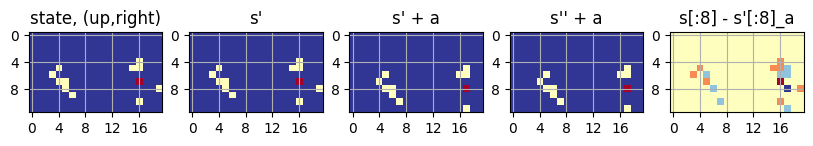

1 1


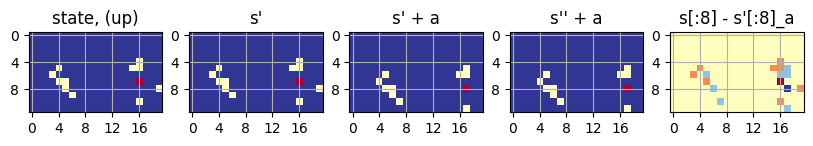

1 2


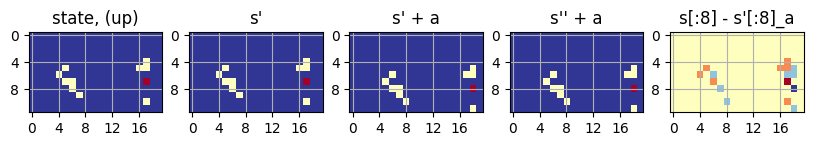

1 2


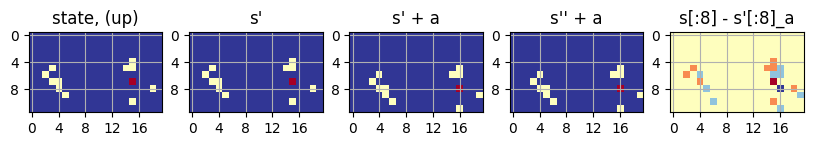

1 1


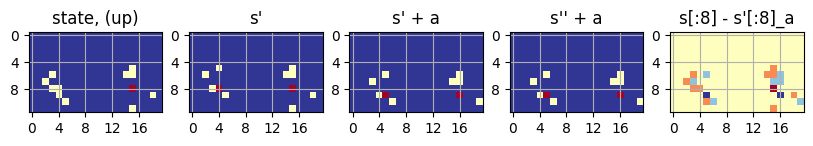

1 0


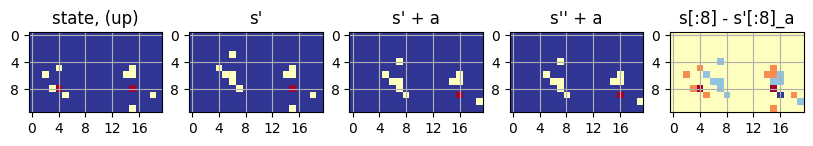

1 2


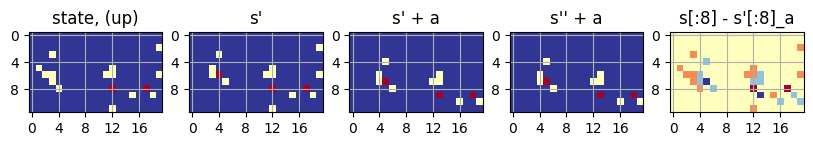

1 0


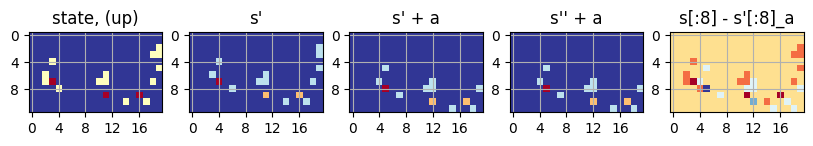

1 0


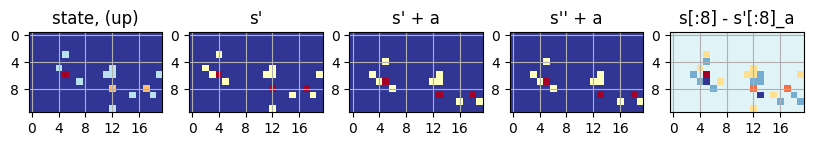

1 0


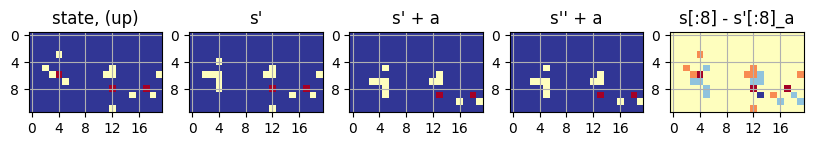

1 0


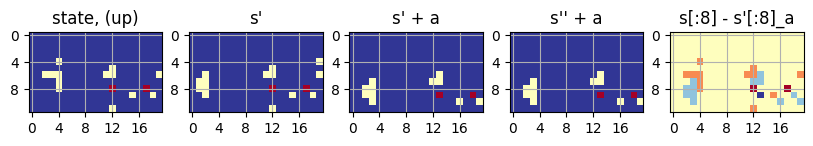

1 0


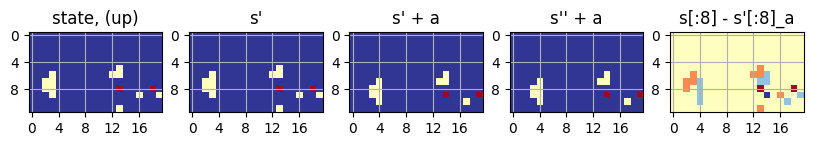

1 0


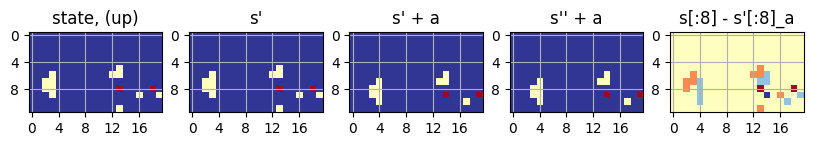

1 0


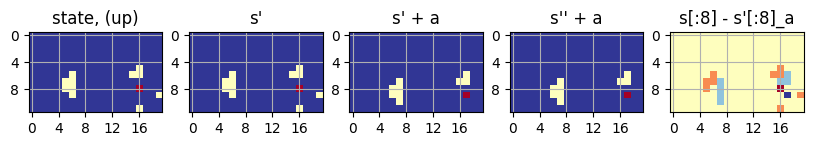

1 0


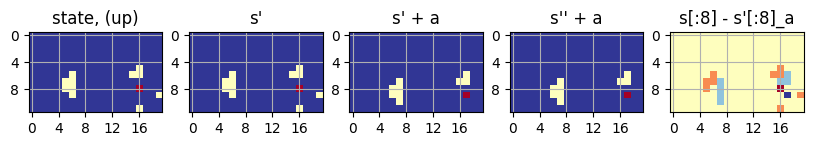

1 2


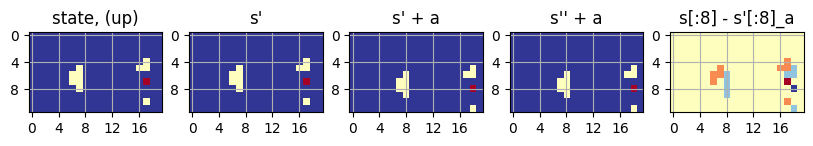

1 0


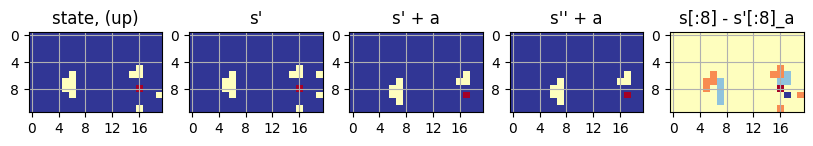

1 0


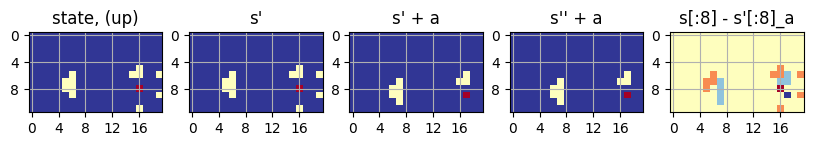

1 0


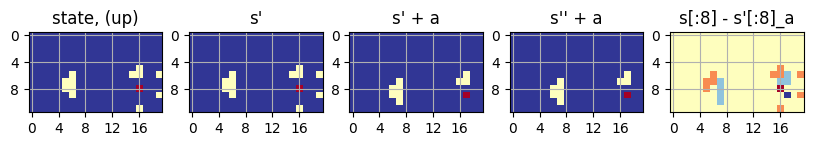

1 0
12
end


In [231]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
from itertools import count
from gym.envs.registration import register
import matplotlib.pyplot as plt

BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # exploration
GAMMA = 0.9                 # reward discount factor
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 5 #2000

N_ACTIONS = 9
N_STATES = (16,12,20)

env = StarObserverEnv()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(16, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(2048, 1)
        self.fc2 = nn.Linear(1, 9)
        
        #(64x32 and 2048x32)
        #1x2048 and 32x64
        
    def forward(self, x):      
        x = self.conv1(x)      
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)      
        x = self.dropout1(x)      
        x = torch.flatten(x, 1)      
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        #output = F.log_softmax(x, dim=1)
        return x #output


class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.eval_net = Net()
        self.target_net =  Net()
        self.train_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory_counter2 = 0      
        self.memory = np.zeros((MEMORY_CAPACITY, 16 , 24 , 20))     # initialize memory
        self.memory2 = np.zeros((MEMORY_CAPACITY, 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)

    def select_action(self, x):
        x = x.float().unsqueeze(0)
        if np.random.uniform() < EPSILON:   # Exploration
            actions_value = self.eval_net.forward(x) # [[0.3, 0.9]]
            action = torch.max(actions_value, 1)[1].data.numpy() # 큰 값의 인덱스를 뽑아냄 [1], (0.9 > 0.3)
            action = action[0] # 1
        else:
            action = np.random.randint(0, N_ACTIONS)
        return action # 0과 1을 이용

dqn = DQN()
dqn.eval_net.load_state_dict(torch.load('DQN_Cartpole.pth'))


def main():
    for i_episode in range(1):
        total_reward = 0
        state = env.reset()
        for t in range(700):
            
            action = dqn.select_action(state)            
            next_state, reward, done, info = env.step(action)
            print(action, reward)
            total_reward += reward

            if done: # 초기 데이터가 모이지 않았을 때
                print(total_reward)
                print("end")
                break
            env.render()
            state = next_state

if __name__ == '__main__':
    main()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(16, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(2048, 32)        
        self.fc2 = nn.Linear(32, 9)
        
    def forward(self, x):      
        x = self.conv1(x)      
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)      
        x = self.dropout1(x)      
        x = torch.flatten(x, 1)      
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        #output = F.log_softmax(x, dim=1)
        return x #output

In [ ]:
#random_data = torch.rand((32, 32, 28, 28))
random_data = torch.randn(4, 16, 12, 20)

my_nn = Net()
result = my_nn(random_data)
#print (result)

##  참고하기 : https://d2.naver.com/helloworld/1994807
## https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html

In [ ]:
env = StarObserverEnv()
obs = env.reset()

for i in range(5):
    action = random.randint(0,8)
    next_state, reward, done, info = env.step(action)    
    env.render()

## Resnet 50

In [ ]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
device = "cuda"
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.conv2 = nn.Conv2d(256, 255, kernel_size=(15,23), stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        
        x = self.conv2(x)
        
        #x.shape =[256, 32, 32]
        x = torch.cat([x,torch.rand(2,1,20,12).cuda()],dim=1)
        x = self.layer3(x) 
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)        
        x = x.view(x.size(0), -1)
        print(x)
        x = self.fc(x)

        return x

In [ ]:
aa = torch.rand(2,5,20,12)
bb = torch.rand(2,1,20,12)
print((aa+bb).shape)
torch.cat([aa,bb],dim=1).shape

In [ ]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 9, True).to(device) 
from torchsummary import summary
summary(resnet50, input_size=(1, 128, 128), device="cuda")

In [ ]:
class Config:
      def __init__(self, **kwargs):
        for key, value in kwargs.items():
              setattr(self, key, value)

lr = 0.0008
epochs = 30
optimizer = 'Adam'

# 파라미터 클래스
config = Config(
    trainloader = trainloader,
    testloader = testloader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [ ]:
ready_to_train=train_test(config)

In [ ]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=10000, gamma=0.5) # 20 step마다 lr조정
epochs = 200
log_interval = 175
ready_to_train.train(epochs, log_interval)

## Old version Visualization

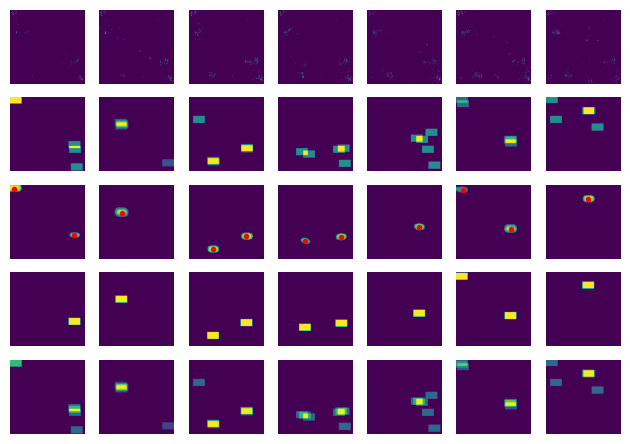

In [29]:
plot_len = int(len(test_img_array))
plot_len = len(test_img_array)
plot_len = int((2001-800)/200)+1
for idx,i in enumerate(range(800,2001,200)):

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
    
    plt.subplot(5,plot_len,idx+1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(test_img_array[i][:8].sum(axis=0).detach().numpy())
    
    plt.subplot(5,plot_len,idx+1+ plot_len)    
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(test_target_array[i].sum(axis=0).detach().numpy())
    
    plt.subplot(5,plot_len,idx+1+ plot_len*2)   
    plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(blur2)    
    
    plt.subplot(5,plot_len,idx+1+plot_len*3)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(aa_zero)
    
    plt.subplot(5,plot_len,idx+1+plot_len*4)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(a123+aa_zero)

plt.tight_layout()
plt.savefig("result55.png",dpi=300)#,bbox_inches=None,pad_inches=300)#, bbox_inches='tight', pad_inches=10)
plt.show()   


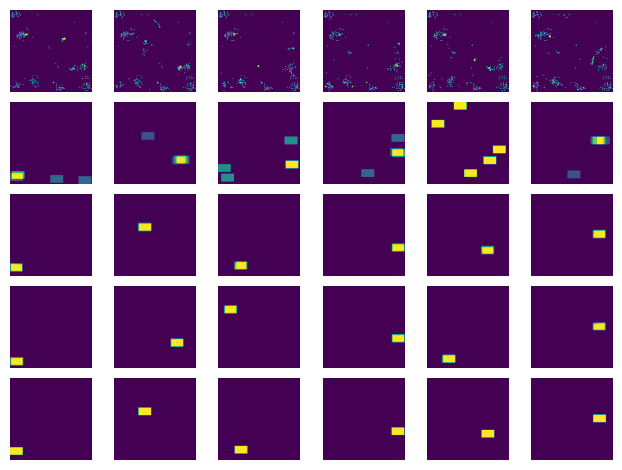

In [36]:
%matplotlib inline
from matplotlib import cm

plot_len = int((3001 - 1500-150*5)/150)+1
for idx,i in enumerate(range(1500+150*5,3001,150)):
    #print(i)

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
        
    acac = test_img_array[i][:8].sum(axis=0).detach().numpy()    
    acac = np.where(acac >= 1, 1.0, 0.0)
    
    plt.subplot(5,plot_len,idx+1)         
    plt.tight_layout()
    plt.axis('off')    
    plt.imshow(acac)
   
    plt.subplot(5,plot_len,idx+1+plot_len*1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(test_target_array[i].sum(axis=0).mul(255).detach().numpy().astype('float32'))
    
    plt.subplot(5,plot_len,idx+1+plot_len*2)         
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
            
    plt.subplot(5,plot_len,idx+1+plot_len*3)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-10][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
#     print(predictions[i][0]['boxes'][0])
    
    coordinates1 = predictions[i][0]['boxes'][0]
    yy1 = np.zeros((128,128))
#     for j in coordinates1:
#         y = j[1]
#         x = j[0]
#         aa_zero1[y-6:y+6,x-10:x+10]=1
    yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1

    
    plt.subplot(5,plot_len,idx+1+plot_len*4)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(yy1)

plt.tight_layout()
plt.savefig("result_late_screen1.png",dpi=500,pad_inches=0,bbox_inches='tight')
plt.show()




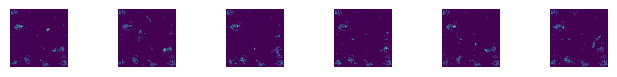

In [37]:
plot_len = int((3001 - 1500-150*5)/150)+1
for idx,i in enumerate(range(1500+150*5,3001,150)):

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
        
    acac = test_img_array[i][:8].sum(axis=0).detach().numpy()    
    acac = np.where(acac >= 1, 1.0, 0.0)
    
    plt.subplot(5,plot_len,idx+1)         
    plt.tight_layout()
    plt.axis('off')    
    plt.imshow(acac)

In [ ]:
from matplotlib import cm

plot_len = int(len(test_img_array))
plot_len = len(test_img_array)
plot_len = int((2001-800)/200)+1
for idx,i in enumerate(range(800,2001,200)):

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
        
    acac = test_img_array[i][:8].sum(axis=0).detach().numpy()    
    acac = np.where(acac >= 1, 1.0, 0.0)
    
    plt.subplot(5,plot_len,idx+1)         
    plt.tight_layout()
    plt.axis('off')    
    plt.imshow(acac)
   
    plt.subplot(5,plot_len,idx+1+plot_len*1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(test_target_array[i].sum(axis=0).mul(255).detach().numpy().astype('float32'))
    
    plt.subplot(5,plot_len,idx+1+plot_len*2)         
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
            
    plt.subplot(5,plot_len,idx+1+plot_len*3)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i][0]['masks'][1].sum(axis=0).mul(255).byte().cpu().detach().numpy())
#     print(predictions[i][0]['boxes'][0])
    
    coordinates1 = predictions[i][0]['boxes'][0]
    yy1 = np.zeros((128,128))
#     for j in coordinates1:
#         y = j[1]
#         x = j[0]
#         aa_zero1[y-6:y+6,x-10:x+10]=1
    yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1

    
    plt.subplot(5,plot_len,idx+1+plot_len*4)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(yy1)

plt.tight_layout()
plt.savefig("result_late_screen1.png",dpi=500,pad_inches=0,bbox_inches='tight')
plt.show()




In [ ]:
from matplotlib import cm

plot_len = int((3001 - 1500-150*5)/150)+1
for idx,i in enumerate(range(1500+150*5,3001,150)):

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
        
    acac = test_img_array[i][:8].sum(axis=0).detach().numpy()    
    acac = np.where(acac >= 1, 1.0, 0.0)
    
    plt.subplot(8,plot_len,idx+1)         
    plt.tight_layout()
    plt.axis('off')    
    plt.imshow(acac)
   
    plt.subplot(8,plot_len,idx+1+plot_len*1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(test_target_array[i].sum(axis=0).mul(255).detach().numpy().astype('float32'))
    
    plt.subplot(8,plot_len,idx+1+plot_len*2)         
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
            
    plt.subplot(8,plot_len,idx+1+plot_len*3)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-2][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
    #print(predictions[i][0]['boxes'][0])
    
    coordinates1 = predictions[i][0]['boxes'][0]
    yy1 = np.zeros((128,128))
    yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1
    
    plt.subplot(8,plot_len,idx+1+plot_len*4)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-4][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
    
    plt.subplot(8,plot_len,idx+1+plot_len*5)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-6][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
    
    plt.subplot(8,plot_len,idx+1+plot_len*6)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-8][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
    
    plt.subplot(8,plot_len,idx+1+plot_len*7)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-10][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())

plt.tight_layout()
plt.savefig("result_late_screen1.png",dpi=500,pad_inches=0,bbox_inches='tight')
plt.show()




In [34]:
yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1
old = np.zeros((1,10))

cumulate_y_diff_lst = []
cumulate_x_diff_lst = []
cumulate_x_y_diff_lst = []
remove_index = []

for i in range(10,len(test_target_array), 1):
#     ymin = int(predictions[i][0]['boxes'][0][1])
#     xmin = int(predictions[i][0]['boxes'][0][0])
#     print(i)
    cumulate_y_diff = 0
    cumulate_x_diff = 0
    if len(remove_index) != 0:
        if i < (remove_index[-1]+10):
            #print(i) 
            continue
        else:
            for j in range(i,i-10,-1):
                y_diff = abs(int(predictions[j][0]['boxes'][0][1]+12)-int(predictions[j-1][0]['boxes'][0][1]+12))
                x_diff = abs(int(predictions[j][0]['boxes'][0][0]+20)-int(predictions[j-1][0]['boxes'][0][1]+20))
                cumulate_y_diff += y_diff
                cumulate_x_diff += x_diff
            if x_diff > 60 or y_diff > 36: #or np.square(x_diff*x_diff + y_diff*y_diff)> 20*20+12*12:
                print("Start newepisode")
                remove_index.append(i)
                continue
                
            cumulate_y_diff_lst.append(cumulate_y_diff)
            cumulate_x_diff_lst.append(cumulate_x_diff)  
    else:
        for j in range(i,i-10,-1):
            y_diff = abs(int(predictions[j][0]['boxes'][0][1]+12)-int(predictions[j-1][0]['boxes'][0][1]+12))
            x_diff = abs(int(predictions[j][0]['boxes'][0][0]+20)-int(predictions[j-1][0]['boxes'][0][1]+20))
            cumulate_y_diff += y_diff
            cumulate_x_diff += x_diff
            if x_diff > 20 or y_diff > 12 : #or np.square(x_diff*x_diff + y_diff*y_diff)> 20*20+12*12:
                print(i,"Start newepisode")
                remove_index.append(i)
                continue
                #break
        cumulate_y_diff_lst.append(cumulate_y_diff)
        cumulate_x_diff_lst.append(cumulate_x_diff)    
    

179 Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newe

In [35]:
yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1
old = np.zeros((1,10))

cumulate_y_diff_lst = []
cumulate_x_diff_lst = []
cumulate_x_y_diff_lst = []
remove_index = []

for i in range(10,len(test_target_array), 1):
#     ymin = int(predictions[i][0]['boxes'][0][1])
#     xmin = int(predictions[i][0]['boxes'][0][0])
#     print(i)
    cumulate_y_diff = 0
    cumulate_x_diff = 0
    if len(remove_index) != 0:
        if i < (remove_index[-1]+10):
            #print(i) 
            continue
        else:
            for j in range(i,i-10,-1):
                y_diff = abs(int(predictions[j][0]['boxes'][0][1]+12)-int(predictions[j-1][0]['boxes'][0][1]+12))
                x_diff = abs(int(predictions[j][0]['boxes'][0][0]+20)-int(predictions[j-1][0]['boxes'][0][1]+20))
                cumulate_y_diff += y_diff
                cumulate_x_diff += x_diff
            if x_diff > 40 or y_diff > 24 : #or np.square(x_diff*x_diff + y_diff*y_diff)> 20*20+12*12:
                print("Start newepisode")
                remove_index.append(i)
                continue
                
            cumulate_y_diff_lst.append(cumulate_y_diff)
            cumulate_x_diff_lst.append(cumulate_x_diff)  
    else:
        for j in range(i,i-10,-1):
            y_diff = abs(int(predictions[j][0]['boxes'][0][1]+12)-int(predictions[j-1][0]['boxes'][0][1]+12))
            x_diff = abs(int(predictions[j][0]['boxes'][0][0]+20)-int(predictions[j-1][0]['boxes'][0][1]+20))
            cumulate_y_diff += y_diff
            cumulate_x_diff += x_diff
            if x_diff > 20 or y_diff > 12 : #or np.square(x_diff*x_diff + y_diff*y_diff)> 20*20+12*12:
                print(i,"Start newepisode")
                remove_index.append(i)
                continue
                #break
        cumulate_y_diff_lst.append(cumulate_y_diff)
        cumulate_x_diff_lst.append(cumulate_x_diff)    
    

179 Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newepisode
Start newe